# Исследование объявлений о продаже квартир

В распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Необходимо научиться определять рыночную стоимость объектов недвижимости. Основная задача — установить параметры, которые влияют на стоимость. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучение общей информации. 

In [1]:
#импортируем библиотеки для работы
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#прочитаем файл с данными (при написании проекта было выявлено, что разделение по столбцам осуществляется с помощью знака табуляции)
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except FileNotFoundError:
    data = pd.read_csv('https://raw.githubusercontent.com/Zarayskaya/real_estate_analysis/main/real_estate_data.csv', sep='\t')


In [3]:
#выведем на экран первые 20 строк датафрейма, общую информацию, описание и сумму явных дубликатов:
def data_info(data):
    data.head(20), data.info(), data.describe(), data.duplicated().sum()
data_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В столбце датафрейма 'first_day_exposition' данные должны быть в формате datetime, столбец 'is_apartment', судя по значению в 11й строке, формата bool, а столбцы 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition' однозначно могут иметь целочисленный формат значений. Изменение типа данных будет чуть ниже.

**Построим гистограммы числовых значений датафрейма:**

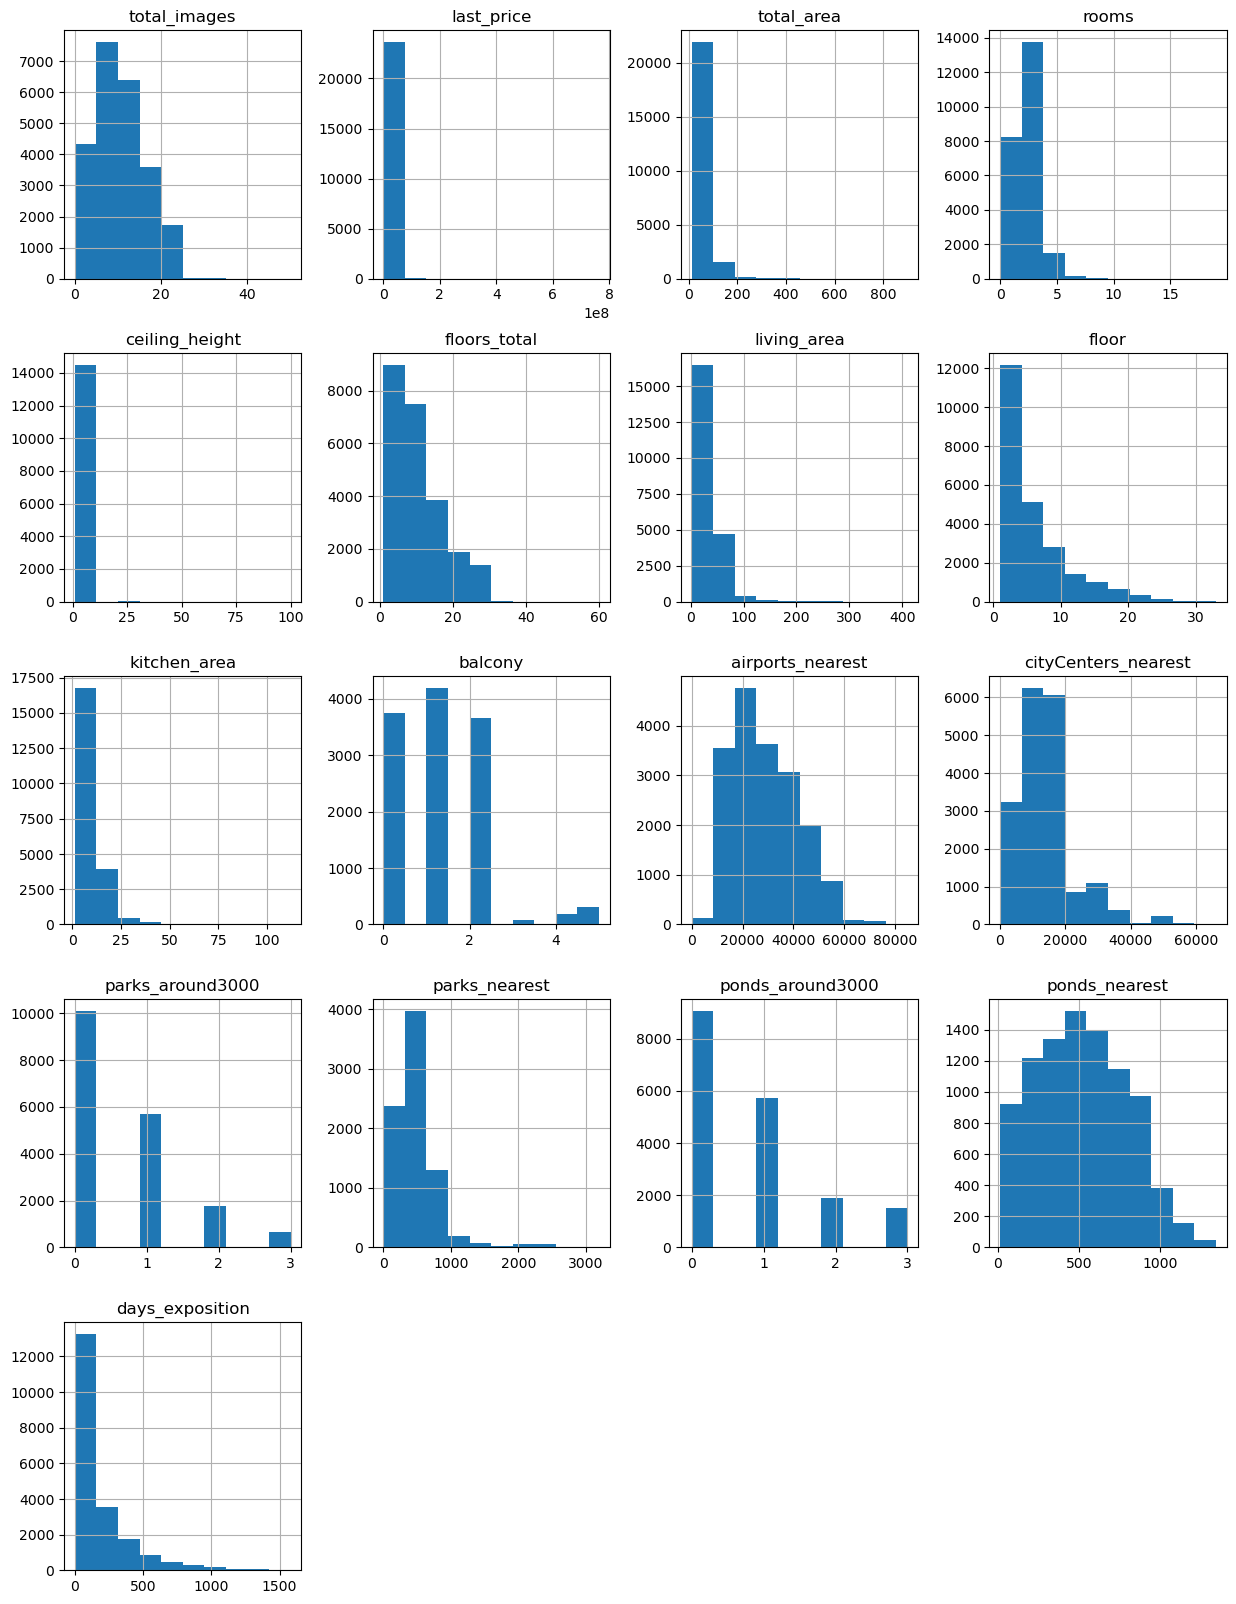

In [4]:
data.hist(figsize=(15, 20));

На представленных гистрограммах видно, что в некоторых столбцах на оси абсцисс Х шкала размечена до слишком больших значений. Так, например, дополнительной проверки данных нужно подвергнуть столбцы 'last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'kitchen_area', 'days_exposition'.  
Также следует обработать ошибку в данных столбца 'balcony', где, судя по графику, появились нецелочисленные значения.

### Предобработка данных

Для удобства работы необходимо привести названия столбцов к единому стилю написания.

In [5]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest', \
                            'parks_around3000':'parks_around_3000', 'ponds_around3000':'ponds_around_3000'})
#проверим выполнение переименования
print(data.columns)

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


In [6]:
#проверим наличие строк-дубликатов
data.duplicated().sum()

0

<h4>Работа с пропусками</h4>
<br>
Выведем количество пропусков в столбцах датафрейма и поочередно обработаем:

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

14 столбцов имеют пропуски. Ниже будут предложены причины их появления и варианты замены значений: 

**1. Столбец 'ceiling_height' имеет пропуски, вероятно, из-за необязательности заполнения ячейки на сайте. Пользователи просто не указывают значение. Предлагается заменить значения в столбце на *медианные*.**

In [8]:
#выведем медианное значение и убедимся, что оно адекватно для заполнения пропусков:
print(data['ceiling_height'].median())
#теперь заполним пропуски им
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)
data['ceiling_height']

2.65


0        2.70
1        2.65
2        2.65
3        2.65
4        3.03
         ... 
23694    3.70
23695    2.65
23696    2.65
23697    3.00
23698    2.50
Name: ceiling_height, Length: 23699, dtype: float64

**2. Столбец 'floors_total' имеет пропуски, скорее всего, из-за технической ошибки. Заменить пропуски в данном столбце на медианные было бы ошибочно, ведь если продающийся объект, например, на 22м этаже, а медианное значение высотности дома 20 этажей, мы получим конфликтующие данные. С учетом малого количества пропусков, предлагается удалить эти строки.**

In [9]:
data.dropna(subset=['floors_total'], inplace=True)

**3. Столбец 'kitchen_area' имеет пропуски с наибольшей вероятностью в тех объектах, где тип квартиры - студия или open-plan. Стоит проверить эту гипотезу, и если это так, заменить площадь кухни у квартир-студий или open-plan на 0. Если же количество комнат квартиры с пропущенным значением в столбце 'kitchen_area' будет больше, то такие строки пока оставим с пропусками.**

In [10]:
#находим подходящие строки в датафрейме - квартира-студия с пропуском в значении площади кухни и заменяем на 0
for index in data.query('(studio == True or open_plan == True) and kitchen_area.isna()').index:
    data.loc[index, 'kitchen_area'] = 0

In [11]:
#проверяем, сколько осталось пропусков
data['kitchen_area'].isna().sum()

2018

Осталось чуть более 2000 пропусков. Это большая часть из тех, что была до замены на 0. Можно заполнить их медианными значениями в соответствии с комнатностью квартир. 

In [12]:
for count in data['rooms'].unique():  #проходим по уникальным значениям в столбце rooms
    data.loc[(data['rooms']==count) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[data['rooms']==count, 'kitchen_area'].median() #заменяем пропущенное значение в столбце kitchen_area на медиану для данного количества комнат

**4. Столбец 'living_area' может иметь пропуски по причине ошибки заполнения пользователем и необязательности формы на сайте.**

Предлагается сделать приближенное вычисление площади через total_area. Для этого посмотрим, есть ли взаимосвязь между total_area и living_area:

In [13]:
#считаем коэффециент корреляции между total area и living area
data['total_area'].corr(data['living_area'])

0.9397704889780091

Полученный коэффициент Пирсона говорит о том, что между значением общей и жилой площади есть прямая взаимосвязь, и оставшиеся пропуски можно заполнить значением, рассчитанным исходя из общей площади.

Теперь можно заполнить оставшиеся пропуски в жилой площади. Для этого можно рассчитать средний коэффициент отношения жилой площади к общей площади за минусом кухни, и с его использованием заполнить пропуски. Но для начала стоит проверить, нет ли аномалии в данных: существуют ли строки, где сумма жилой площади и кухни больше, чем общая:

In [14]:
data.query('(living_area+kitchen_area) > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,NaN,...,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,NaN,...,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,NaN,...,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
601,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,NaN,...,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
696,1,3364930.0,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,NaN,...,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22680,4,2100000.0,23.60,2016-02-25T00:00:00,1,2.75,25.0,17.70,23,NaN,...,9.00,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,119.0
23102,0,5800000.0,66.00,2017-06-09T00:00:00,5,2.65,5.0,55.50,1,NaN,...,15.05,0.0,Санкт-Петербург,12007.0,11933.0,0.0,NaN,0.0,NaN,21.0
23191,3,1900000.0,18.90,2016-04-04T00:00:00,1,2.65,16.0,16.00,12,NaN,...,9.00,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,115.0
23202,13,4919880.0,67.92,2018-10-23T00:00:00,2,2.65,3.0,63.00,3,NaN,...,13.04,NaN,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,60.0


176 записей в датафрейме уже были с ошибкой. Чуть позже они будут удалены. Сейчас необходимо дозаполнить пропуски в living area:

In [15]:
#считаем средний коэффициент жилой площади относительно общей за минусом площади кухни
living_coeff = (data['living_area']/(data['total_area']-data['kitchen_area'])).mean()
#заполняем пропуски с использованием коэффициента, округляем результат до сотых
for index in data.query('living_area.isna()').index:
    data.loc[index,'living_area'] = round(data.loc[index,'total_area']*living_coeff,2)

После заполнения пропусков, заново проверяем количество "аномалий" в площади:

In [16]:
data.query('(living_area+kitchen_area) > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,NaN,...,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
322,6,2000000.0,25.00,2017-02-07T00:00:00,1,2.65,5.0,17.31,5,False,...,9.00,0.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,45.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,NaN,...,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
546,0,6000001.0,25.00,2018-11-16T00:00:00,1,3.00,5.0,17.31,5,False,...,9.00,NaN,Санкт-Петербург,25169.0,3871.0,1.0,207.0,1.0,776.0,17.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,NaN,...,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23102,0,5800000.0,66.00,2017-06-09T00:00:00,5,2.65,5.0,55.50,1,NaN,...,15.05,0.0,Санкт-Петербург,12007.0,11933.0,0.0,NaN,0.0,NaN,21.0
23191,3,1900000.0,18.90,2016-04-04T00:00:00,1,2.65,16.0,16.00,12,NaN,...,9.00,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,115.0
23202,13,4919880.0,67.92,2018-10-23T00:00:00,2,2.65,3.0,63.00,3,NaN,...,13.04,NaN,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,60.0
23500,7,2850000.0,29.00,2018-02-11T00:00:00,1,2.65,9.0,20.08,9,NaN,...,9.00,NaN,Санкт-Петербург,26953.0,12051.0,0.0,NaN,0.0,NaN,45.0


281 квартира имеет некорректную площадь. Эти строки неоходимо удалить:

In [17]:
#удаляем строки, где общая площадь меньше, чем сумма жилой и кухни:
data.drop(labels = (data.query('(living_area+kitchen_area) > total_area').index), axis = 0, inplace = True)

In [18]:
#еще раз проверяем пропуски
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20604
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11333
locality_name              47
airports_nearest         5425
city_centers_nearest     5402
parks_around_3000        5401
parks_nearest           15352
ponds_around_3000        5401
ponds_nearest           14372
days_exposition          3142
dtype: int64

**5. Столбец 'is_apartment' имеет пропуски по причине не установленной галочки "апартаменты" в форме на сайте. А, значит, все пропущенные значения можно заменить на False, то есть "не апартаменты".**

In [19]:
#замена всех пропусков стобца на bool-значение
data['is_apartment'].fillna(value=False, inplace=True)

**6. Столбец 'balcony' имеет пропуски из-за отсуствия балкона в квартире. Заменить пропуски на 0.**

In [20]:
#меняем все пропуски в столбце на 0
data['balcony'].fillna(value=0, inplace=True)

**7. Столбец 'locality_name' имеет пропущенные значения, вероятно, из-за ошибки выгрузки данных**  
Возможно, многие пропущенные значения находятся в Санкт-Петербурге. Для этого проверим, какое максимальное значение удаленности от центра города для квартир в СПб:

In [21]:
data.query('locality_name=="Санкт-Петербург"')['city_centers_nearest'].max()

29493.0

Проверим, сколько строк с пропусками в пределах 30 км от центра города:

In [22]:
#делаем срез с пропусками в названии города и в пределах 30 км от центра
data.query('locality_name.isna() and city_centers_nearest < 29493')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.70,2016-04-15T00:00:00,3,3.55,5.0,50.80,2,False,...,8.80,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2603,20,3351765.0,42.70,2015-09-20T00:00:00,1,2.65,24.0,15.60,3,False,...,10.70,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.40,2015-10-11T00:00:00,2,2.65,24.0,33.10,21,False,...,8.20,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.50,2016-05-28T00:00:00,2,2.65,5.0,30.80,5,False,...,6.50,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0
4151,17,17600000.0,89.50,2014-12-09T00:00:00,2,3.00,8.0,39.62,7,False,...,13.38,0.0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0
4189,7,9200000.0,80.00,2015-12-10T00:00:00,3,4.00,4.0,52.30,3,False,...,10.40,0.0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0
4670,1,5500000.0,83.00,2015-08-14T00:00:00,3,2.65,7.0,57.47,6,False,...,9.50,0.0,NaN,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0
5343,19,13540000.0,85.50,2016-01-20T00:00:00,3,2.65,7.0,59.10,5,False,...,8.30,4.0,NaN,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0
5707,7,3700000.0,30.00,2016-04-29T00:00:00,1,2.65,24.0,20.00,23,False,...,9.00,0.0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0
6765,20,4895892.0,60.70,2015-03-12T00:00:00,2,2.65,24.0,31.90,3,False,...,12.20,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,468.0


37 строк с пропущенным значением в названии города, заполним пропуски:

In [23]:
#в выбранном срезе заменяем все пропуски в столбце locality_name на "Санкт-Петербург"
for index in data.query('locality_name.isna() and city_centers_nearest < 29493').index:
    data.loc[index, 'locality_name'] = "Санкт-Петербург"

Оставшиеся пропуски можно удалить

In [24]:
data.dropna(subset=['locality_name'], inplace=True)

**8. Столбцы 'parks_around_3000' и 'ponds_around_3000' имеют пропуски из-за того, что в радиусе 3 км от объекта нет парков или водоемов, поэтому заменяем пропуски нулем.**

In [25]:
#меняем все пропуски в столбце на 0
data['parks_around_3000'].fillna(value=0, inplace=True)
data['ponds_around_3000'].fillna(value=0, inplace=True)

**9. Столбцы 'parks_nearest', 'ponds_nearest' имеют пропуски, вероятно, из-за того, что у объекта нет поблизости ни парка, ни водоема.** Пропущенные данные предлагается оставить, дабы они не повлияли на результаты исследования. Однако пропуски в столбцах 'parks_nearest', 'ponds_nearest' предлагается заменить *медианным* значением в том случае, если в данной строке в соответствующих столбцах 'parks_around_3000' и 'ponds_around_3000' имеется ненулевое значение. Тогда пропуск будет означать техническую ошибку. Проверим:

In [26]:
#проверяем, есть ли ошибка в столбце parks_nearest
data.query('parks_around_3000 != 0 and parks_nearest.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition


In [27]:
#проверяем, есть ли ошибка в столбце ponds_nearest
data.query('ponds_around_3000 != 0 and ponds_nearest.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition


Как видно, нет ни одной строки, где необходимо было бы заменить расстояние медианным значением.

**10. Столбец 'days_exposition' имеет пропуски, вероятно, из-за того, что квартиры еще не сняты с публикации.** Количество пропусков велико, удалять строки неправильно. Можно высчитать количество дней от даты публикации до даты выгрузки, однако это тоже будет не совсем верно, т.к. в дальнейшем нужно будет исследовать данный столбец, и такие значения могут повлиять на статистику, а на самом деле эти объекты еще продаются, и неизвестно, как долго еще будут продаваться. Поэтому пропуски решено оставить.

**11. Столбцы 'airports_nearest', 'city_centers_nearest' имеют удивительно схожее количество пропусков.** Предположительно, строки с пропусками - это объекты, расположенные в удаленных от Санкт-Петербурга городах Ленинградской области. Стоит проверить, какое количество пропусков имеет locality_name НЕ Санкт-Петербург, а далее заменить пропуски на средние значения в соответствии с населенным пунктом. Для обработки пропусков таким образом, сначала необходимо устранить дубликаты в locality_name.

<hr style="border-top: 3px solid purple; "></hr>
<h4>Удаление дубликатов</h4>

Для корректной работы необходимо проверить строковые данные - названия населенных пунктов. Список уникальных значений столбца выглядит так:

In [28]:
print(data['locality_name'].unique())
print(len(data['locality_name'].unique()))

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

Всего 364 значения, причем явно видны повторы, возникшие из-за нюансов написания (поселок-посёлок и тд). Выведем все "приставки" к названиям населенных пунктов в список:

In [29]:
names = [
        'городской поселок ', 'городской посёлок ', 'деревня ', 'коттеджный поселок ', 'коттеджный посёлок ', 'поселок городского типа ', 
        'поселок станции ', 'посёлок городского типа ', 'посёлок при железнодорожной станции ', 'посёлок станции ', 
        'садоводческое некоммерческое товарищество ', 'садовое товарищество ', 'село ', 'поселок ', 'посёлок '
    ]

Необходимо "отрезать" все приставки из списка от названий населенных пунктов, чтобы устранить неявные дубликаты. Удобнее сделать это через функцию:

In [30]:
def locality_name_review(locality_name): #передаем в функцию столбец с названиями населенных пунктов
    for n in names:                      #перебираем значения в списке с "приставками"
        if locality_name.startswith(n):  #если название населенного пункта начинается с приставки, то...
            return locality_name.replace(n,'') #отрезаем приставку, оставляя только название
    return locality_name                 #а если нет приставки, то оставляем как есть
data['locality_name'] = data['locality_name'].apply(locality_name_review)    #теперь перезаписывем столбец в датафрейме    

Проверка выполнения функции и нового количества уникальных значений:

In [31]:
print(data['locality_name'].unique())
print(len(data['locality_name'].unique()))

['Санкт-Петербург' 'Шушары' 'Янино-1' 'Парголово' 'Мурино' 'Ломоносов'
 'Сертолово' 'Петергоф' 'Пушкин' 'Кудрово' 'Коммунар' 'Колпино'
 'Красный Бор' 'Гатчина' 'Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'Новое Девяткино' 'Металлострой' 'Лебяжье' 'Сиверский' 'Молодцово'
 'Кузьмоловский' 'Новая Ропша' 'Павловск' 'Пикколово' 'Всеволожск'
 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк' 'Куттузи' 'Аннино'
 'Ефимовский' 'Плодовое' 'Заклинье' 'Торковичи' 'Первомайское'
 'Красное Село' 'Понтонный' 'Сясьстрой' 'Старая' 'Лесколово' 'Новый Свет'
 'Сланцы' 'Путилово' 'Ивангород' 'Шлиссельбург' 'Никольское' 'Зеленогорск'
 'Сосновый Бор' 'Оржицы' 'Кальтино' 'Романовка' 'Бугры' 'Рощино' 'Кириши'
 'Луга' 'Волосово' 'Отрадное' 'Павлово' 'Оредеж' 'Копорье' 'Молодёжное'
 'Тихвин' 'Победа' 'Нурма' 'Синявино' 'Тосно' 'Стрельна' 'Бокситогорск'
 'Александровская' 'Лопухинка' 'Пикалёво' 'Терволово' 'Советский'
 'Подпорожье' 'Петровское' 'Токсово' 'Сельцо' 'Вырица' 'Кипень' 'Келози'
 'Вартемяги' 'Тельмана' '

<hr style="border-top: 3px solid purple; "></hr>

In [32]:
#выведем строки с пропусками в city_centers_nearest и airport_nearest для объектов, расположенных не в СПб
data.query('city_centers_nearest.isna() and airports_nearest.isna() and locality_name != "Санкт-Петербург"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,False,...,9.10,0.0,Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,False,...,8.81,0.0,Мурино,NaN,NaN,0.0,NaN,0.0,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.65,5.0,30.00,5,False,...,9.00,0.0,Сертолово,NaN,NaN,0.0,NaN,0.0,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,False,...,11.00,2.0,Кудрово,NaN,NaN,0.0,NaN,0.0,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.65,9.0,22.71,2,False,...,9.00,0.0,Коммунар,NaN,NaN,0.0,NaN,0.0,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,False,...,5.50,0.0,Дзержинского,NaN,NaN,0.0,NaN,0.0,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.65,5.0,17.50,4,False,...,6.00,0.0,Тихвин,NaN,NaN,0.0,NaN,0.0,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.00,4,False,...,8.50,0.0,Тосно,NaN,NaN,0.0,NaN,0.0,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.70,1,False,...,8.70,0.0,Рождествено,NaN,NaN,0.0,NaN,0.0,NaN,NaN


Предположение верно: из 5394 пропусков, 5334 - общие и не в Санкт-Петербурге. Построим сводную таблицу, сгруппировав по населенному пункту:

In [33]:
nearest_mean = data.query('locality_name != "Санкт-Петербург"') \
    .pivot_table(index='locality_name', values=['airports_nearest','city_centers_nearest'], aggfunc='mean')
display(nearest_mean)                           

,airports_nearest,city_centers_nearest
locality_name,,
Александровская,12896.500000,27468.000000
Белоостров,57769.000000,38868.000000
Зеленогорск,73300.250000,54617.583333
Колпино,26364.397015,32102.014925
Красное Село,26610.028736,30034.741379
Кронштадт,67469.263158,49195.726316
Левашово,52693.000000,25727.000000
Лисий Нос,55302.333333,27613.333333
Ломоносов,48308.280303,50739.969697


Получена таблица с названиями населенных пунктов и средней удаленностью от аэропорта и центра города. Проверим, есть ли среди интересующих 5334 строк названия населенных пунктов из сводной таблицы:

In [34]:
data.query('locality_name in @nearest_mean and city_centers_nearest.isna() and airports_nearest.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition


Таким образом, получено подтверждение, что пропуски в столбцах city_centers_nearest и airports_nearest соотносятся с определенным списком населенных пунктов, для которых нет других численных значений, а значит, заменить их невозможно.

In [35]:
#сбросим индексы после удаления пропусков
data.reset_index(drop=True, inplace=True)

После удаления пропусков, они остались только в тех столбцах, что и планировалось. Можно обрабатывать датафрейм дальше:

In [36]:
#проверяем оставшиеся пропуски в датафрейме
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5417
city_centers_nearest     5394
parks_around_3000           0
parks_nearest           15342
ponds_around_3000           0
ponds_nearest           14362
days_exposition          3141
dtype: int64

<h4>Работа с типами данных</h4>

Необходимо проверить, все ли столбцы имеют корректный тип данных:

In [37]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
city_centers_nearest    float64
parks_around_3000       float64
parks_nearest           float64
ponds_around_3000       float64
ponds_nearest           float64
days_exposition         float64
dtype: object

В первую очередь заметно, что столбец first_day_exposition имеет строковый тип, а должен быть datetime. Также несколько столбцов имеет вещественный тип данных, хотя там должны быть целочисленные значения. Необходимо проверить данные и изменить тип в столбцах floors_total, balcony, ponds_around_3000, parks_around_3000

In [38]:
#переведем столбец с первым днем публикации в формат datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

После замены формата, в датафрейме сохранились только даты публикации, что удобно для дальнейшей обработки и анализа. Также переведем вышеуказанные столбцы в целочисленные значения:

In [39]:
#меняем на целоцисленные значения данные в 4 столбцах
data = data.astype({'floors_total':'int', 'balcony':'int', \
                    'parks_around_3000':'int', 'ponds_around_3000':'int'})

In [40]:
#меняем float64 на float32
data_float64 = list(data.select_dtypes(include='float64'))
data[data_float64] = data[data_float64].astype('float32')

Изменение типа данных - необходимый шаг для дальнейшего исследования. К тому же перевод в целочисленные значения избавит от некорректных значений с дробным остатком там, где их быть не может.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23322 entries, 0 to 23321
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23322 non-null  int64         
 1   last_price            23322 non-null  float32       
 2   total_area            23322 non-null  float32       
 3   first_day_exposition  23322 non-null  datetime64[ns]
 4   rooms                 23322 non-null  int64         
 5   ceiling_height        23322 non-null  float32       
 6   floors_total          23322 non-null  int64         
 7   living_area           23322 non-null  float32       
 8   floor                 23322 non-null  int64         
 9   is_apartment          23322 non-null  bool          
 10  studio                23322 non-null  bool          
 11  open_plan             23322 non-null  bool          
 12  kitchen_area          23322 non-null  float32       
 13  balcony         

<h4>Работа с аномальными данными</h4>

Необходимо проверить, нет ли в количественных данных аномальных значений, выбросов и ошибок формата. Для этого подойдет описание столбцов таблицы:

In [42]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,23322.000000,23322.0,23322.000000,23322.000000,23322.000000,23322.000000,23322.000000,23322.000000,23322.000000,23322.000000,17905.000000,17928.000000,23322.000000,7980.000000,23322.000000,8960.000000,20181.000000
mean,9.901681,6559329.5,60.599907,2.079624,2.722598,10.639010,35.281319,5.858117,10.330880,0.594074,28801.060547,14195.364258,0.470629,490.470306,0.591416,518.232239,181.358810
std,5.681170,10913093.0,35.681973,1.078242,0.969627,6.576097,23.072199,4.855281,5.686653,0.961550,12638.108398,8628.880859,0.749208,340.295441,0.885049,277.571777,220.016083
min,0.000000,12190.0,14.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3450000.0,40.099998,1.000000,2.600000,5.000000,19.000000,2.000000,7.100000,0.000000,18573.000000,9234.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4650000.0,52.000000,2.000000,2.650000,9.000000,30.500000,4.000000,9.000000,0.000000,26736.000000,13093.000000,0.000000,455.000000,0.000000,503.000000,96.000000
75%,14.000000,6800000.0,70.000000,3.000000,2.700000,16.000000,43.000000,8.000000,11.500000,1.000000,37277.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,763000000.0,900.000000,19.000000,100.000000,60.000000,436.899994,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Для начала необходимо найти аномалии. В представленной таблице сразу заметны странные значения в столбцах:  
- last_price (минимальное значение всего 12190)  
- ceiling_height (максимальное значение 100)
- floors_total (60 этажей - нетипично для застройки в черте Санкт-Петербурга)   
- living_area (минимальное значение 2)
- airports_nearest (минимальное значение 0)  

Также стоит внимательнее изучить значения в столбцах:  
- total_area (стоит проверить минимальное и максимальное значения) 
- rooms (19-комнатная квартира) 
- days_exposition (1580 дней - продажа больше 4 лет)

**Для оценки значений в столбце last_price предлагается в первую очередь рассмотреть диаграмму размаха. Для удобства можно ограничить верхнюю границу значений ниже максимума в столбце:**

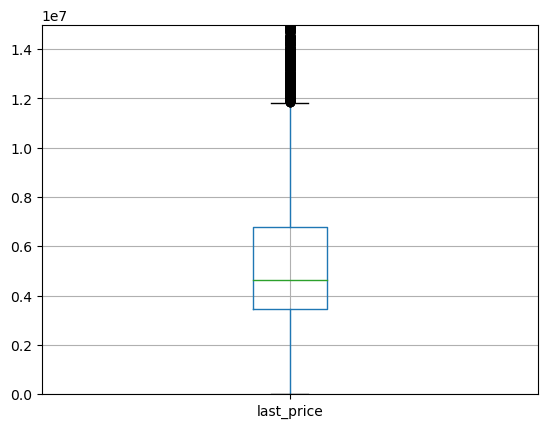

In [43]:
plt.ylim(0, 15000000) #ограничим верхнее значение 15ю млн, что больше Q3.
data.boxplot('last_price');

Как видно, все значения выше 12 млн рассматриваются как выбросы, при этом значения, близкие к нулю - входят в нормальные значения. Это нетипично для цен на недвижимость, поэтому стоит подробнее изучить значения ниже первого квартиля, а также выше межквартильного размаха.

In [44]:
#сформируем таблицу с ценами ниже 3 млн и отсортируем по возрастанию
data.query('last_price < 3000000').sort_values(by='last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
8669,7,12190.0,109.000000,2019-03-20,2,2.75,25,32.000000,25,False,...,40.5,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8.0
17186,7,430000.0,30.400000,2019-04-22,1,2.65,2,16.000000,1,False,...,6.0,0,Сланцы,NaN,NaN,0,NaN,0,NaN,NaN
14673,5,430000.0,54.000000,2018-06-26,2,2.65,3,37.389999,3,False,...,8.7,0,Свирь,NaN,NaN,0,NaN,0,NaN,44.0
16026,18,440000.0,40.000000,2018-07-10,1,2.65,5,27.700001,1,False,...,9.0,0,Старополье,NaN,NaN,0,NaN,0,NaN,45.0
17399,0,450000.0,36.500000,2018-02-01,1,2.65,5,17.299999,4,False,...,8.5,1,Ям-Тесово,NaN,NaN,0,NaN,0,NaN,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7138,8,2999000.0,42.630001,2017-11-27,0,2.65,16,25.700001,2,False,...,0.0,2,Кудрово,NaN,NaN,0,NaN,0,NaN,45.0
15386,18,2999999.0,35.000000,2017-10-03,1,2.50,12,21.000000,6,False,...,7.0,0,Санкт-Петербург,37153.0,11468.0,0,NaN,0,NaN,93.0
6462,18,2999999.0,33.099998,2018-03-26,1,2.65,4,15.900000,4,False,...,6.5,0,Колпино,24870.0,30656.0,3,288.0,3,456.0,4.0
20178,7,2999999.0,53.700001,2018-02-20,2,2.65,4,36.000000,4,False,...,7.0,1,Всеволожск,NaN,NaN,0,NaN,0,NaN,45.0


Проявилось ошибочное значение в строке 8669 - стоимость объекта всего 12190, при этом однозначно сказать, какая финальная цена - 12 млн или 120 млн невозможно, поэтому просто удалим ее:

In [45]:
data.drop(axis=0, index=8669, inplace=True)

Большинство минимальных значений стоимости - это удаленные населенные пункты Ленинградской области. Стоит переделать выборку только по Санкт-Петербургу:

In [46]:
#сформируем таблицу с ценами ниже 3 млн только в Санкт-Петербурге и отсортируем по возрастанию
data.query('last_price < 3000000 and locality_name == "Санкт-Петербург"').sort_values(by='last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
19333,5,1190000.0,14.000000,2018-07-29,1,2.65,5,11.000000,1,False,...,2.0,0,Санкт-Петербург,9898.0,11122.0,0,NaN,0,NaN,4.0
4192,8,1200000.0,49.099998,2018-10-21,4,2.50,5,36.900002,1,False,...,5.2,0,Санкт-Петербург,17539.0,12313.0,0,NaN,0,NaN,44.0
8631,1,1350000.0,18.799999,2017-11-22,0,2.75,19,15.800000,1,False,...,0.0,0,Санкт-Петербург,37636.0,14479.0,0,NaN,1,1127.0,128.0
23021,10,1600000.0,92.000000,2018-07-10,3,3.00,6,13.000000,1,False,...,10.0,0,Санкт-Петербург,20881.0,4465.0,1,937.0,3,167.0,3.0
17475,12,1800000.0,117.300003,2016-02-18,5,2.65,4,23.600000,2,False,...,12.9,0,Санкт-Петербург,24670.0,5238.0,0,NaN,0,NaN,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9891,8,2998000.0,31.000000,2016-05-21,1,2.65,10,17.000000,9,False,...,7.0,0,Санкт-Петербург,38841.0,10132.0,1,326.0,1,501.0,144.0
7041,17,2999000.0,31.000000,2018-02-26,1,2.60,5,16.000000,1,False,...,6.0,0,Санкт-Петербург,17957.0,16176.0,1,796.0,0,NaN,68.0
544,11,2999000.0,33.500000,2017-03-30,1,2.00,15,17.500000,6,False,...,6.5,0,Санкт-Петербург,33972.0,11746.0,1,520.0,1,949.0,270.0
9646,13,2999000.0,32.400002,2017-10-16,1,2.60,9,16.600000,1,False,...,8.1,0,Санкт-Петербург,44474.0,11110.0,1,170.0,1,335.0,32.0


Заметим странные значения - объекты с большой площадью, но малой ценой (строки 23021 и 17475 например). Судя по жилой площади, это были объявления о продаже комнат в коммунальных квартирах. Однако при расчете стоимости квадратного метра будет учитываться общая площадь. Такие значения явно не отражают реальную ситуацию, поэтому можно задать ограничение на минимальную цену и площадь, а аномалии отбросить:

In [47]:
#удалим предложения свыше 50 метров и до 3 млн в Санкт-Петербурге
data.drop(labels = (data.query('last_price < 3000000 and locality_name == "Санкт-Петербург" and total_area > 50').index), axis = 0, inplace = True)

На диаграмме размаха выбросы начинаются от 12 млн, необходимо проверить эти значения:

In [48]:
#сформируем таблицу с ценами выше 12 млн и отсортируем по возрастанию
data.query('last_price > 12000000').sort_values(by='last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
608,1,12036000.0,100.000000,2014-11-27,3,2.65,16,52.000000,3,False,...,11.00,1,Санкт-Петербург,37407.0,8434.0,1,456.0,2,454.0,606.0
21258,4,12054000.0,78.150002,2016-03-13,3,2.84,9,46.500000,6,False,...,14.85,2,Санкт-Петербург,27370.0,6072.0,1,763.0,3,587.0,219.0
443,13,12084000.0,86.599998,2018-07-05,3,2.65,13,59.959999,6,False,...,9.50,0,Санкт-Петербург,37412.0,8370.0,1,392.0,2,359.0,90.0
22423,14,12100000.0,88.800003,2017-02-07,3,2.65,21,52.200001,3,False,...,15.40,2,Санкт-Петербург,17950.0,16952.0,1,679.0,3,361.0,135.0
6814,10,12100000.0,83.000000,2017-09-19,2,2.70,13,57.470001,6,False,...,11.50,0,Санкт-Петербург,37412.0,8370.0,1,392.0,2,359.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15408,20,300000000.0,618.000000,2017-12-18,7,3.40,7,258.000000,5,False,...,70.00,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111.0
1418,19,330000000.0,190.000000,2018-04-04,3,3.50,7,95.000000,5,False,...,40.00,0,Санкт-Петербург,23011.0,1197.0,3,519.0,3,285.0,233.0
14471,15,401300000.0,401.000000,2016-02-20,5,2.65,9,204.000000,9,False,...,24.00,3,Санкт-Петербург,21912.0,2389.0,1,545.0,1,478.0,393.0
19235,8,420000000.0,900.000000,2017-12-06,12,2.80,25,409.700012,25,False,...,112.00,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106.0


Почти две тысячи значений - это не выбросы. Вероятно ,стоит увеличить планку цены, от которой значения уже считаются аномальными. Для этого можно проанализироавть гистограмму распределения значений:

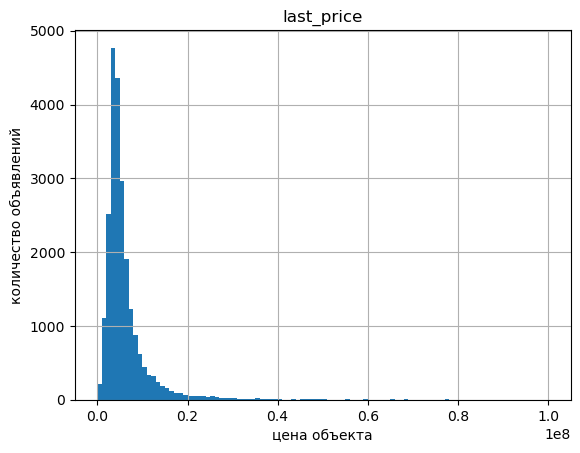

In [49]:
data.hist('last_price', bins=100, range=(0,100000000));
plt.xlabel("цена объекта");
plt.ylabel("количество объявлений");

Видно, что гистограмма "сливается" с осью Ох после 40 млн. Поэтому пересортируем таблицу со значениями от 40 млн:

In [50]:
#сформируем таблицу с ценами выше 40 млн и отсортируем по возрастанию
data.query('last_price > 40000000').sort_values(by='last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
21168,1,40488000.0,144.600006,2019-04-01,3,3.00,11,82.900002,8,False,...,16.200001,0,Санкт-Петербург,28282.0,6941.0,2,365.0,3,215.0,NaN
407,1,40662000.0,151.000000,2014-12-09,3,2.65,8,85.000000,3,False,...,23.000000,1,Санкт-Петербург,33255.0,5975.0,1,630.0,3,100.0,594.0
11525,0,41484000.0,160.000000,2015-02-28,3,2.65,6,86.000000,3,False,...,21.000000,1,Санкт-Петербург,32999.0,5856.0,1,607.0,3,757.0,513.0
16775,11,41900000.0,170.000000,2018-02-26,4,2.65,9,62.000000,4,False,...,56.000000,2,Санкт-Петербург,26055.0,4800.0,1,648.0,1,779.0,120.0
19994,8,42000000.0,374.000000,2017-04-09,7,2.65,4,239.399994,3,False,...,51.000000,0,Пушкин,15595.0,27749.0,3,62.0,3,274.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15408,20,300000000.0,618.000000,2017-12-18,7,3.40,7,258.000000,5,False,...,70.000000,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111.0
1418,19,330000000.0,190.000000,2018-04-04,3,3.50,7,95.000000,5,False,...,40.000000,0,Санкт-Петербург,23011.0,1197.0,3,519.0,3,285.0,233.0
14471,15,401300000.0,401.000000,2016-02-20,5,2.65,9,204.000000,9,False,...,24.000000,3,Санкт-Петербург,21912.0,2389.0,1,545.0,1,478.0,393.0
19235,8,420000000.0,900.000000,2017-12-06,12,2.80,25,409.700012,25,False,...,112.000000,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106.0


179 предельно-высоких значения, от которых стоит избавиться:

In [51]:
#удалим предложения свыше 40 млн
data.drop(labels = (data.query('last_price > 40000000').index), axis = 0, inplace = True)

**Значения в столбце ceiling_height также требуют обработки. Стоит посмотреть сколько выбросов имеется среди значений:**

In [52]:
#выведем на экран 10 самых малых и 15 самых больших значений высот потолка и количество записей по ним:
display(data.pivot_table(index='ceiling_height', values='total_area', aggfunc='count').head(10))
display(data.pivot_table(index='ceiling_height', values='total_area', aggfunc='count').tail(15))

,total_area
ceiling_height,
1.00,1
1.20,1
1.75,1
2.00,11
2.20,1
2.25,1
2.30,4
2.34,1
2.40,23


,total_area
ceiling_height,
5.3,1
5.5,1
5.8,1
8.0,3
8.3,1
10.3,1
14.0,1
20.0,1
22.6,1


В сводной таблице видно, что есть единичные значения высот менее 2 метров, и также есть высоты более 14 метров. Вероятнее всего, 24, 25, 26 и 27 метров - это ошибки, и на самом деле это 2,4, 2,5 и тд метра соответственно. Необходимо отбросить аномально малые и аномально большие значения, а также изменить значения в диапазоне 22,6-27,0

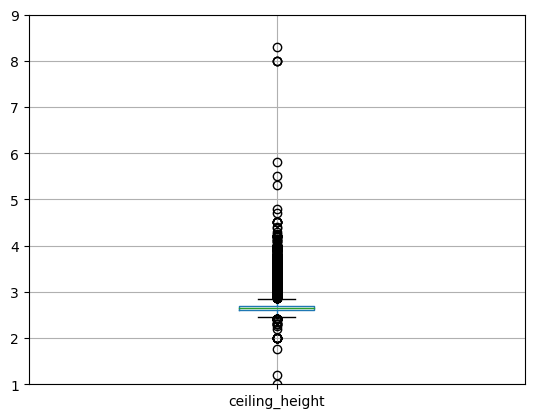

In [53]:
plt.ylim(1,9)
data.boxplot('ceiling_height');

Согласно диаграмме размаха, значения ниже 2,4 метров и больше 2.7 - выбросы. Однако "плотность" точек снижается только выше 5 метров. Поэтому после замены значений, предлагается оставить именно диапазон высот от 2,4 до 5

In [54]:
#изменим значение 22.6 на 2.6
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] != 22.6, 2.6)

In [55]:
#изменим все значения 24-27 на 2.4-2.7:
def ceiling_height_review(ceiling_height): #передаем в функцию столбец с высотами
    if 24 <= ceiling_height < 100:  #если высота лежит в диапазоне
        return ceiling_height/10   #делим значение на 10
    return ceiling_height                 #а если нет, то оставляем как есть
data['ceiling_height'] = data['ceiling_height'].apply(ceiling_height_review) #перезаписываем столбец

In [56]:
#удаляем экстремально маленькие и большие значения
data.drop(labels=(data.query('ceiling_height < 2.4 or ceiling_height > 5').index), axis=0, inplace=True)

**Проверка столбца floors_total:**

Для визуального удобства произведем сортировку количества объектов по каждому общему количеству этажей:

In [57]:
#сводная таблица, которая покажет частоту встречаемости того или иного значения высотности дома
data.pivot_table(index='floors_total', values='floor', aggfunc='count')

,floor
floors_total,
1,24
2,374
3,653
4,1169
5,5700
6,870
7,564
8,353
9,3714


Последние значения 52 и 60 аномальны, можно их исключить:

In [58]:
data.drop(labels= (data.query('floors_total == 52 or floors_total == 60').index), axis = 0, inplace=True)

**Проверка столбца living_area**

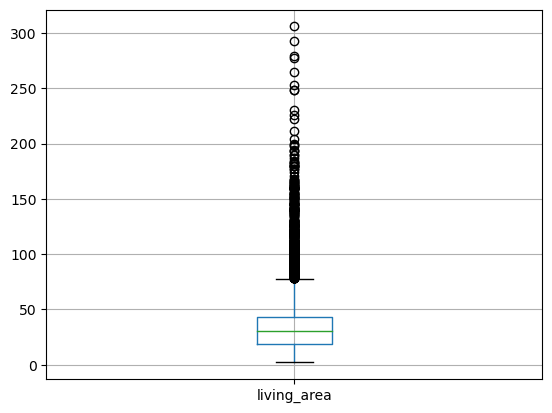

In [59]:
data.boxplot('living_area');

На графике видны редкие выбивающиеся значения больше 200 метров:

In [60]:
data.query('living_area > 200')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
855,5,25000000.0,363.000000,2017-12-23,14,3.16,5,222.000000,4,False,...,16.600000,0,Санкт-Петербург,38076.0,7950.0,0,NaN,2,435.0,418.0
2546,6,30900000.0,338.600006,2017-10-16,7,3.86,6,230.000000,4,False,...,20.000000,0,Санкт-Петербург,24957.0,5641.0,0,NaN,0,NaN,406.0
3628,12,28789000.0,441.980011,2019-01-23,4,2.65,6,306.019989,6,False,...,35.049999,0,Санкт-Петербург,20552.0,5181.0,0,NaN,0,NaN,NaN
5795,0,38000000.0,400.000000,2019-03-15,7,3.60,3,276.959991,1,False,...,20.000000,0,Санкт-Петербург,24889.0,5457.0,1,271.0,0,NaN,NaN
6137,8,34000000.0,470.299988,2018-01-14,4,2.65,3,248.699997,3,False,...,40.000000,0,Санкт-Петербург,43756.0,15459.0,1,852.0,3,122.0,179.0
10035,9,35000000.0,295.000000,2017-12-16,4,2.65,5,204.259995,4,False,...,11.000000,0,Санкт-Петербург,26711.0,5559.0,0,NaN,1,785.0,90.0
10527,6,32894076.0,364.700012,2019-05-02,7,3.32,3,252.520004,1,False,...,20.000000,5,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
14266,6,32250000.0,374.600006,2018-06-09,19,2.65,5,264.500000,2,False,...,27.600000,0,Санкт-Петербург,19497.0,3574.0,0,NaN,2,548.0,114.0
15366,5,34000000.0,356.000000,2017-09-12,7,3.55,7,248.500000,5,False,...,18.900000,0,Санкт-Петербург,24363.0,4931.0,3,173.0,0,NaN,20.0
16654,14,29000000.0,292.200012,2017-01-12,9,3.35,5,225.899994,4,False,...,32.900002,1,Санкт-Петербург,24892.0,5162.0,2,263.0,0,NaN,825.0


In [61]:
#удаляем 13 строк с максимальным значением жилой площади
data.drop(labels = (data.query('living_area > 200').index), axis = 0, inplace = True)

**Проверка столбца airport_nearest:**

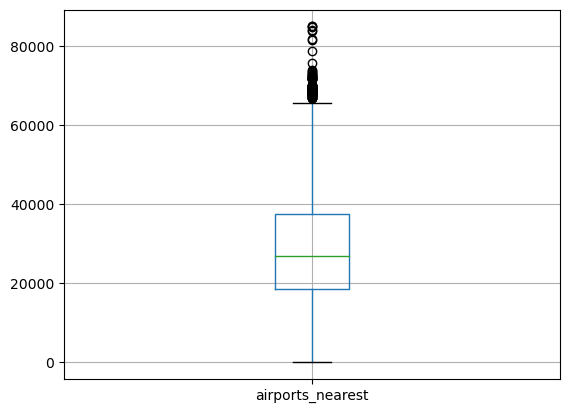

In [62]:
data.boxplot('airports_nearest');

На графике видны выборочные значения после 70 000 метров. Необходимо проверить, какое количество объектов попадает в эти условия. Также в методе describe было обнаружено значение равное нулю, что тоже имеет аномальную природу, поэтому срез будет строиться по двум параметрам:

In [63]:
data.query('airports_nearest < 1000 or airports_nearest > 70000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
299,6,3500000.0,31.000000,2016-04-05,1,2.55,5,17.500000,1,False,...,5.4,0,Зеленогорск,72005.0,53104.0,3,92.0,1,571.0,168.0
372,18,8400000.0,84.000000,2018-06-26,2,2.75,3,41.000000,1,False,...,13.0,0,Зеленогорск,73827.0,54926.0,0,NaN,0,NaN,201.0
569,7,4000000.0,59.000000,2017-07-23,3,2.50,5,37.000000,1,False,...,7.0,0,Молодёжное,84665.0,65764.0,0,NaN,0,NaN,NaN
928,17,3015000.0,31.200001,2019-04-16,1,2.50,3,17.500000,1,False,...,5.8,0,Зеленогорск,75646.0,56745.0,0,NaN,1,347.0,NaN
2006,19,6100000.0,50.000000,2018-03-24,2,2.60,5,29.000000,5,False,...,9.0,1,Зеленогорск,71618.0,52717.0,3,37.0,1,926.0,72.0
2931,13,3200000.0,46.299999,2018-03-31,2,2.50,3,29.200001,2,False,...,7.0,1,Зеленогорск,81355.0,62454.0,0,NaN,0,NaN,205.0
3431,4,6400000.0,67.199997,2016-10-10,3,2.65,6,43.000000,1,False,...,12.0,0,Зеленогорск,71597.0,52696.0,3,112.0,1,408.0,316.0
3882,10,4250000.0,38.000000,2017-11-30,1,2.70,3,20.000000,3,False,...,8.0,0,Зеленогорск,72078.0,53177.0,3,533.0,2,123.0,179.0
4381,6,2300000.0,31.000000,2016-05-26,1,2.65,3,12.000000,1,False,...,9.0,0,Зеленогорск,78527.0,59626.0,0,NaN,0,NaN,232.0
4839,11,5500000.0,49.000000,2017-10-24,2,2.50,5,29.000000,3,False,...,8.5,1,Зеленогорск,71529.0,52628.0,3,296.0,2,521.0,25.0


30 значений, вполне можно удалить. Однако в данном столбце есть пропуски в тех населенных пунктах, что значительно удалены от СПб, поэтому удаление каких-либо аномалий не будет на 100 процентов отражать действительность. Поэтому можно удалить только одну строку, где расстояние до аэропорта равно нулю:

In [64]:
data.drop(axis=0, index=20753, inplace=True)

**Проверка столбца city_centers_nearest:**

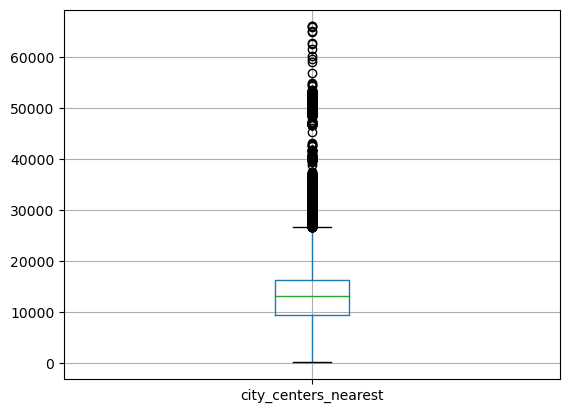

In [65]:
data.boxplot('city_centers_nearest');

Видны более редкие выбросы выше отметки 57 000 м от центра. Опять же, как и в столбце с расстоянием до аэропорта. Удаление таких значений нецелесообразно из-за пропусков

In [66]:
data.query('city_centers_nearest > 57000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
569,7,4000000.0,59.000000,2017-07-23,3,2.50,5,37.000000,1,False,...,7.0,0,Молодёжное,84665.0,65764.0,0,NaN,0,NaN,NaN
2931,13,3200000.0,46.299999,2018-03-31,2,2.50,3,29.200001,2,False,...,7.0,1,Зеленогорск,81355.0,62454.0,0,NaN,0,NaN,205.0
4381,6,2300000.0,31.000000,2016-05-26,1,2.65,3,12.000000,1,False,...,9.0,0,Зеленогорск,78527.0,59626.0,0,NaN,0,NaN,232.0
5148,15,3650000.0,53.799999,2018-09-24,3,2.50,4,36.900002,3,False,...,5.2,0,Молодёжное,83758.0,64857.0,0,NaN,0,NaN,121.0
5266,19,3600000.0,50.599998,2019-03-19,2,2.50,5,29.900000,4,False,...,7.0,1,Молодёжное,84853.0,65952.0,0,NaN,0,NaN,NaN
9504,8,4200000.0,51.400002,2014-12-10,2,2.55,5,31.000000,2,False,...,6.0,1,Молодёжное,84869.0,65968.0,0,NaN,0,NaN,1194.0
11072,8,4250000.0,32.000000,2018-02-04,1,2.65,2,20.000000,2,False,...,7.0,0,Зеленогорск,72713.0,59052.0,3,148.0,1,671.0,24.0
16315,13,3200000.0,52.799999,2017-06-20,2,2.55,5,29.900000,3,False,...,8.3,0,Ломоносов,53042.0,61495.0,2,223.0,0,NaN,240.0
18593,15,3600000.0,57.599998,2019-02-08,3,2.55,3,41.299999,2,False,...,6.5,1,Зеленогорск,81607.0,62706.0,0,NaN,0,NaN,13.0
20420,1,3300000.0,43.500000,2016-02-16,2,2.55,4,27.200001,2,False,...,5.0,1,Молодёжное,84006.0,65105.0,0,NaN,0,NaN,1043.0


Вполне можно лишиться большинства записей в одном небольшом городе, если просто отсечь выбросы

**Проверка столбца days_exposition**

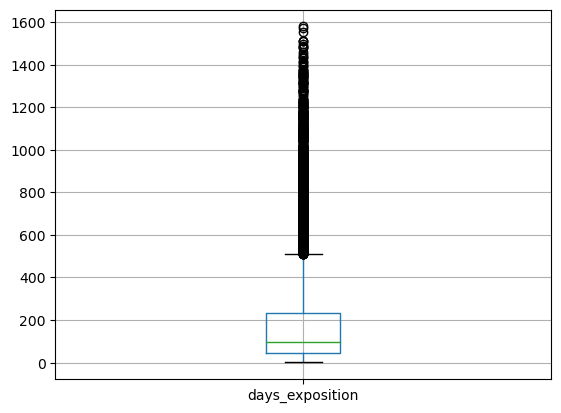

In [67]:
data.boxplot('days_exposition');

На графике видно колоссальное количество вбросовых значений. Действительно, срок продажи свыше 1,5 лет выглядит странно. Однако судя по плотности, значений много. Снижение плотности наблюдается свыше 1500 дней. Эти значения необходимо отсечь.

In [68]:
data.drop(labels=(data.query('days_exposition > 1500').index), axis=0, inplace=True)

**Проверка столбца kitchen_area:**

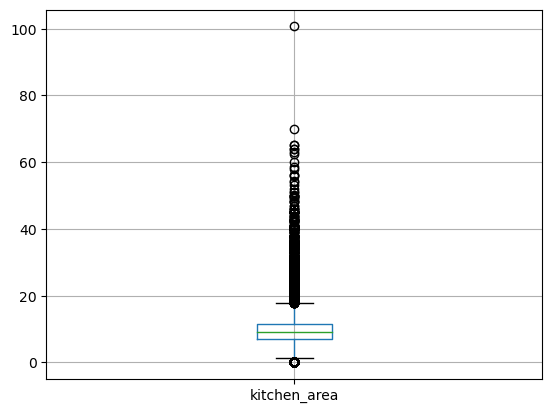

In [69]:
data.boxplot('kitchen_area');

Пик в значении ноль нормален - это площади кухонь в квартирах-студиях. А вот значения свыше 60 - редкость. От них можно избавиться.

In [70]:
data.drop(labels=(data.query('kitchen_area > 60').index), axis=0, inplace=True)

**Проверка столбца total_area:**

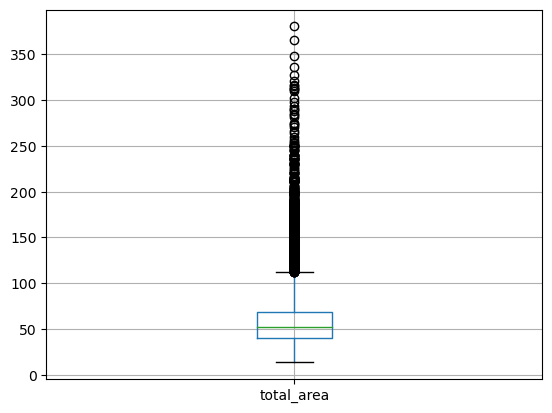

In [71]:
data.boxplot('total_area');

Видны редкие вбросовые значения выше 260 квадратных метров. Можно проверить количество и удалить.

In [72]:
data.query('total_area > 260')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
3223,1,25092624.0,266.200012,2015-12-08,5,3.00,3,155.100006,1,False,...,11.600000,0,Санкт-Петербург,32106.0,5065.0,0,NaN,2,471.0,660.0
4094,6,23000000.0,272.600006,2018-01-11,10,3.14,7,145.899994,7,False,...,18.799999,1,Санкт-Петербург,10726.0,12169.0,1,191.0,1,531.0,NaN
4144,8,24900000.0,281.100006,2018-02-21,6,3.30,5,193.500000,3,False,...,26.600000,0,Санкт-Петербург,21480.0,2453.0,3,75.0,1,795.0,126.0
4476,25,26000000.0,290.000000,2017-11-16,5,2.80,17,141.000000,16,False,...,45.000000,0,Санкт-Петербург,30094.0,5608.0,0,NaN,1,153.0,120.0
4975,20,35000000.0,380.000000,2017-08-17,6,2.65,3,198.000000,2,False,...,50.000000,0,Пушкин,18490.0,30643.0,1,527.0,1,668.0,15.0
7556,20,40000000.0,315.000000,2017-04-20,5,3.50,6,182.000000,4,False,...,37.000000,0,Санкт-Петербург,22526.0,3175.0,1,1028.0,1,399.0,81.0
7824,12,39000000.0,312.000000,2017-07-27,6,2.65,5,194.000000,5,False,...,41.000000,0,Санкт-Петербург,26711.0,5559.0,0,NaN,1,785.0,613.0
9262,10,16073000.0,263.799988,2019-01-30,3,2.65,19,182.649994,4,False,...,23.420000,0,Санкт-Петербург,18805.0,4400.0,0,NaN,0,NaN,35.0
9414,10,23500000.0,313.000000,2017-02-13,9,3.20,6,179.199997,5,False,...,13.200000,0,Санкт-Петербург,38435.0,10138.0,1,146.0,0,NaN,NaN
9425,2,24900000.0,312.000000,2015-11-27,5,3.00,2,127.000000,2,False,...,24.000000,1,Санкт-Петербург,38164.0,11736.0,1,287.0,1,203.0,392.0


In [73]:
data.drop(labels=(data.query('total_area > 260').index), axis=0, inplace=True)

**Проверка столбца rooms**

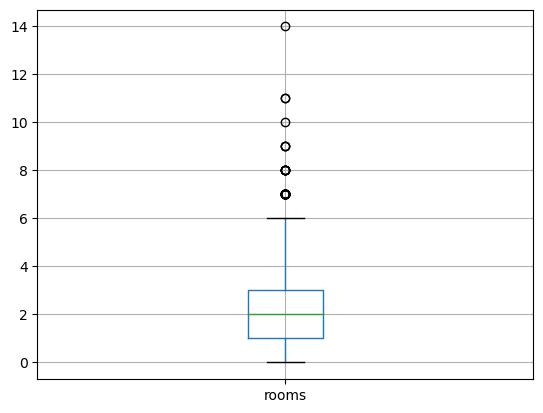

In [74]:
data.boxplot('rooms');

Явные выбросы выше значения 6. Опять же, стоит проверить количество записей, и если их мало - удалить.

In [75]:
data.query('rooms >6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
639,3,17500000.0,183.699997,2018-07-01,11,3.40,7,138.800003,7,False,...,13.300000,0,Санкт-Петербург,23606.0,3148.0,0,NaN,0,NaN,NaN
671,20,24900000.0,249.000000,2015-08-13,7,2.65,5,180.000000,4,False,...,20.000000,1,Санкт-Петербург,24810.0,6108.0,0,NaN,0,NaN,781.0
739,9,29500000.0,188.800003,2017-03-04,7,2.70,2,119.300003,1,False,...,10.200000,0,Санкт-Петербург,20965.0,814.0,0,NaN,2,267.0,246.0
802,7,16500000.0,229.000000,2016-02-25,8,2.65,6,160.000000,5,False,...,25.000000,0,Санкт-Петербург,23968.0,4536.0,1,243.0,0,NaN,806.0
844,18,15000000.0,134.000000,2017-10-27,7,2.65,4,88.000000,3,False,...,12.000000,0,Санкт-Петербург,22670.0,3936.0,1,803.0,1,387.0,150.0
1789,0,15000000.0,179.000000,2017-04-09,7,2.65,5,126.400002,5,False,...,20.900000,0,Санкт-Петербург,20070.0,3186.0,1,104.0,1,803.0,15.0
1916,20,16000000.0,184.399994,2018-10-21,7,2.65,6,125.699997,5,False,...,23.100000,0,Санкт-Петербург,23382.0,2923.0,1,525.0,1,791.0,109.0
2009,3,13520000.0,162.800003,2018-03-21,7,3.00,4,121.599998,4,False,...,15.900000,0,Санкт-Петербург,20631.0,1899.0,3,360.0,3,153.0,NaN
2230,15,17800000.0,164.000000,2019-02-12,7,2.65,7,125.900002,7,False,...,12.000000,0,Санкт-Петербург,20139.0,2670.0,2,41.0,3,397.0,NaN
2428,18,7900000.0,201.500000,2018-08-17,7,2.65,2,139.520004,2,False,...,20.000000,0,Парголово,54990.0,20665.0,0,NaN,0,NaN,35.0


51 строка, удалим:

In [76]:
data.drop(labels=(data.query('rooms >6').index), axis=0, inplace=True)

После удаления значений, сбросим индексы:

In [77]:
#сбросим индексы после удаления пропусков
data.reset_index(drop=True, inplace=True)

In [78]:
#после всех операций еще раз проверим датафрейм
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22995 entries, 0 to 22994
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22995 non-null  int64         
 1   last_price            22995 non-null  float32       
 2   total_area            22995 non-null  float32       
 3   first_day_exposition  22995 non-null  datetime64[ns]
 4   rooms                 22995 non-null  int64         
 5   ceiling_height        22995 non-null  float64       
 6   floors_total          22995 non-null  int64         
 7   living_area           22995 non-null  float32       
 8   floor                 22995 non-null  int64         
 9   is_apartment          22995 non-null  bool          
 10  studio                22995 non-null  bool          
 11  open_plan             22995 non-null  bool          
 12  kitchen_area          22995 non-null  float32       
 13  balcony         

### Посчитайте и добавьте в таблицу новые столбцы

In [79]:
#добавим столбец с ценой 1 метра:
data['one_sqm_price'] = round(data['last_price'] / data['total_area'],2)

In [80]:
#добавим столбец с днем недели
data['weekday'] = data['first_day_exposition'].dt.weekday

In [81]:
#добавим столбец с месяцем публикации
data['month'] = data['first_day_exposition'].dt.month

In [82]:
#добавим столбец с годом публикации
data['year'] = data['first_day_exposition'].dt.year

In [83]:
#добавим столбец с типом этажа квартиры
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'
data['floor_category'] = data.apply(floor_category, axis=1)

In [84]:
#добавим столбец с расстоянием до центра города в километрах
data['city_centers_in_kilometers'] = round((data['city_centers_nearest'] / 1000),0)

In [85]:
#проверим все новые добавленные столбцы
pd.set_option('display.max_columns', None) #эту строчку нагло украла у коллеги, которая поделилась комментарием от ревьюера
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,one_sqm_price,weekday,month,year,floor_category,city_centers_in_kilometers
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.367188,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.00,2,Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.789062,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.710938,3,8,2015,другой,14.0
3,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,8.0
4,10,2890000.0,30.400000,2018-09-10,1,2.65,12,14.400000,5,False,False,False,9.10,0,Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95065.789062,0,9,2018,другой,NaN
5,6,3700000.0,37.299999,2017-11-02,1,2.65,26,10.600000,6,False,False,False,14.40,1,Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,99195.710938,3,11,2017,другой,19.0
6,5,7915000.0,71.599998,2019-04-18,2,2.65,24,49.580002,22,False,False,False,18.90,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN,110544.703125,3,4,2019,другой,12.0
7,20,2900000.0,33.160000,2018-05-23,1,2.65,27,15.430000,26,False,False,False,8.81,0,Мурино,NaN,NaN,0,NaN,0,NaN,189.0,87454.773438,2,5,2018,другой,NaN
8,18,5400000.0,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0,88524.593750,6,2,2017,другой,15.0
9,5,5050000.0,39.599998,2017-11-16,1,2.67,12,20.299999,3,False,False,False,8.50,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137.0,127525.257812,3,11,2017,другой,14.0


### Анализ данных

<h4>Изучение параметров объектов</h4>

1. Общая площадь

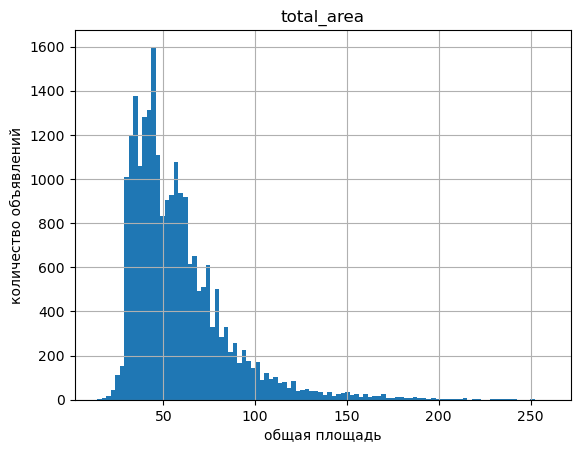

In [86]:
data.hist('total_area', bins=100);
plt.xlabel("общая площадь");
plt.ylabel("количество объявлений");

На гистограмме видно, что основная масса квартир имеет площадь от 30 до 70 метров, причем наибольшее количество именно площадью до 50 метров. Делаем вывод, что малогабаритные квартиры до 50м составляют основной объем предложения.

2. Жилая площадь

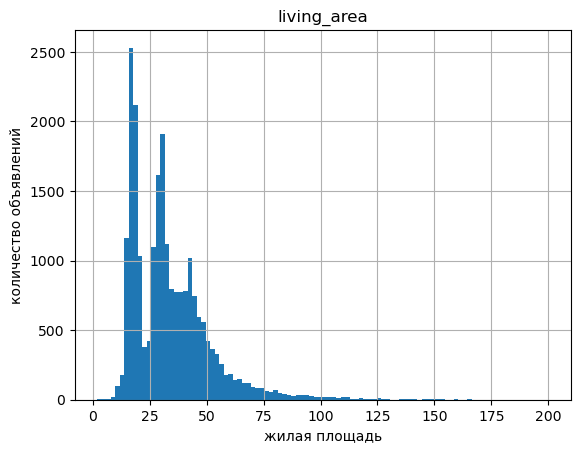

In [87]:
data.hist('living_area', bins=100);
plt.xlabel("жилая площадь");
plt.ylabel("количество объявлений");

Видны острые пиковые значения в районе 15-20 метров, а также около 30 метров. Это соответствует предыдущему выводу - преобладают малогабаритные квартиры.

3. Площадь кухни

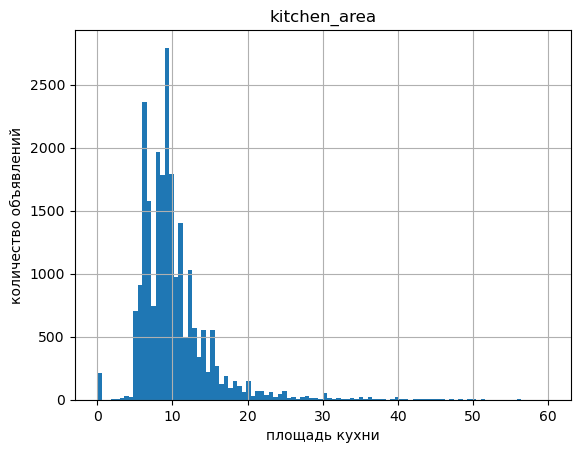

In [88]:
data.hist('kitchen_area', bins=100);
plt.xlabel("площадь кухни");
plt.ylabel("количество объявлений");

Небольшой пик в нуле - замененные значения для квартир-студий. Основная масса квартир имеет кухню в диапазоне от 7 до 10 м, а вот свыше 20 - предложения уже редкие.

4. Цена объекта

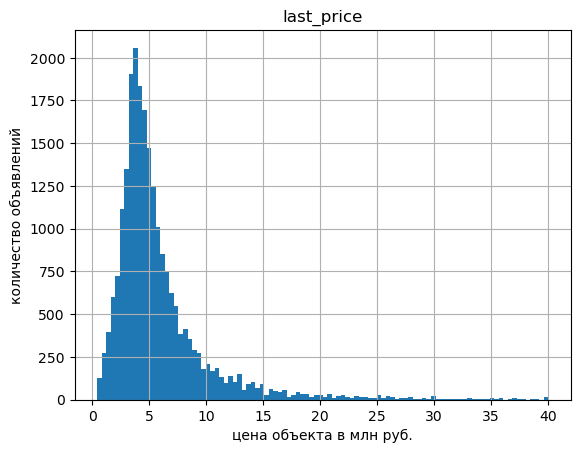

In [89]:
data['last_price'] = data['last_price'] / 1000000
data.hist('last_price', bins=100);
plt.xlabel("цена объекта в млн руб.");
plt.ylabel("количество объявлений");

Гистограмма распределения цен показывает, что основной объем сосредоточен в диапазоне от 2 до 7 млн примерно. Предложения свыше 10 млн - редкие, а свыше 20 млн - единичные.

5. Количество комнат

2    7842
1    7778
3    5706
4    1124
5     274
0     192
6      79
Name: rooms, dtype: int64

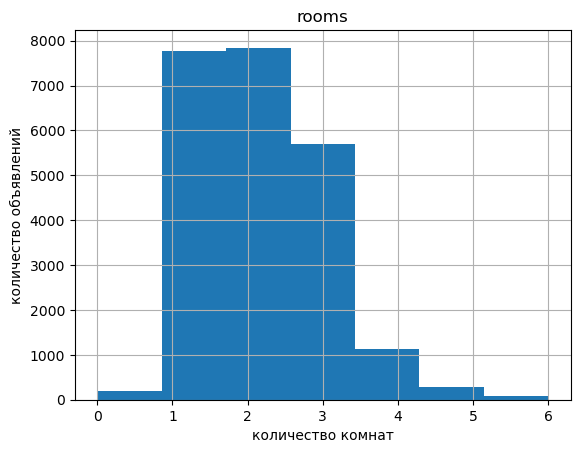

In [90]:
data.hist('rooms', bins=7);
plt.xlabel("количество комнат");
plt.ylabel("количество объявлений");
data['rooms'].value_counts()

Почти все предложения - это 1-2 комнатные квартиры. Студий даже меньше, чем 5-комнатных квартир, что весьма удивительно. Возможно, часть студий отмечены в базе как 1-комнатные квартиры

6. Высота потолков

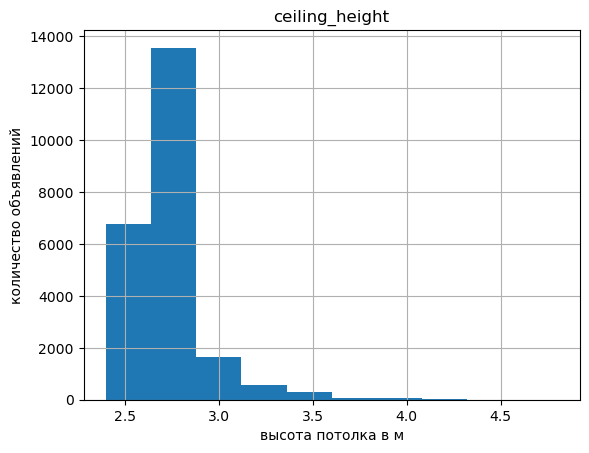

In [91]:
data.hist('ceiling_height', bins=10);
plt.xlabel("высота потолка в м");
plt.ylabel("количество объявлений");

Почти все объекты имеют высоту потолка около 2,7 м. Варианты с 3м потолками весьма редки, а более высокие потолки - единичный случай.

7. Этаж квартиры

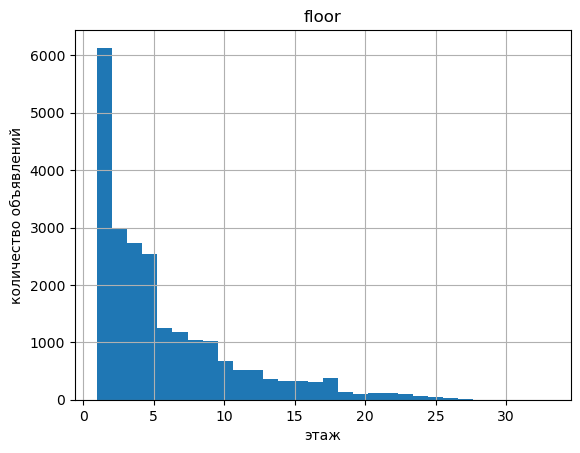

In [92]:
data.hist('floor', bins=30);
plt.xlabel("этаж");
plt.ylabel("количество объявлений");

Удивительно, однако большинство объектов расположено не выше 5го этажа, а почти четверть -  не выше 3го.

8. Тип этажа квартиры

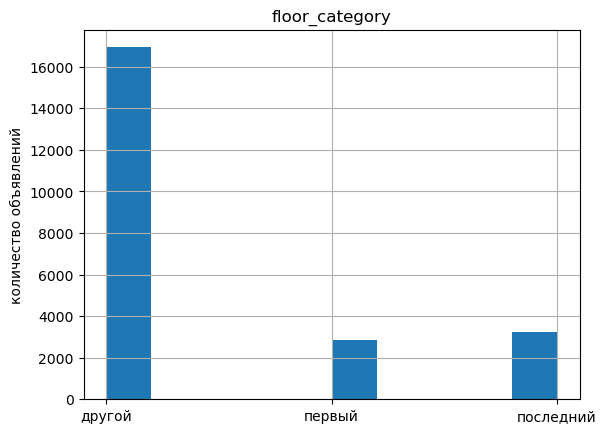

In [93]:
data['floor_category'].hist();
plt.title("floor_category");
plt.ylabel("количество объявлений");

Первых этажей меньше, чем последних. Если изначально неправильно интерпретировать предыдущую диаграмму, и подумать, что пик расположен именно на первом этаже, то выведя гистограмму типа этажа становится понятно, что квартиры на первом этаже - самые непопулярные.

9. Общее количество этажей в доме

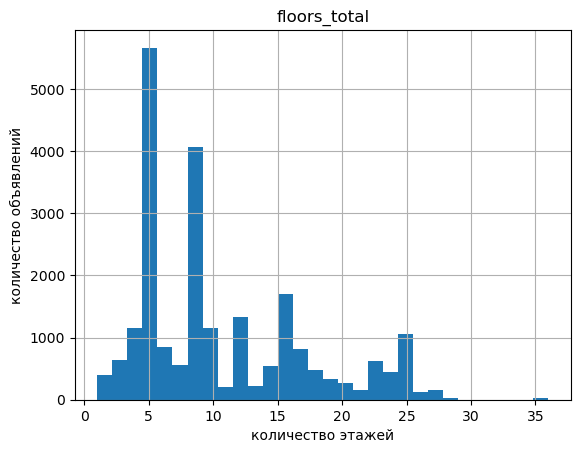

In [94]:
data.hist('floors_total', bins=30);
plt.xlabel("количество этажей");
plt.ylabel("количество объявлений");

Наиболее часто-встречающиеся значения в районе 5 и 9 этажей. Вероятно 5этажные "хрущевки" и 9этажные панельные дома 404 серии - самые популярные объекты в Санкт-Петербурге

10. Расстояние до центра города в метрах

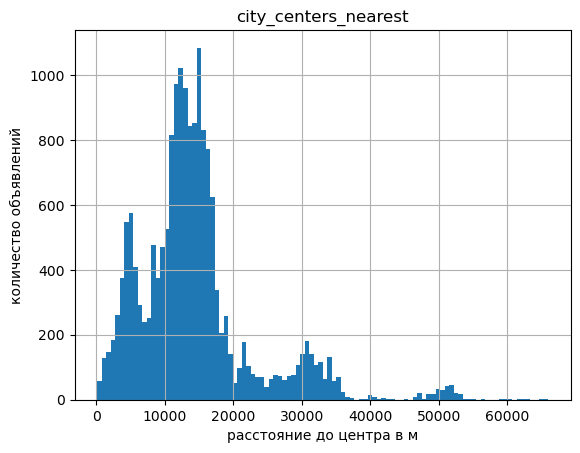

In [95]:
data.hist('city_centers_nearest', bins=100);
plt.xlabel("расстояние до центра в м");
plt.ylabel("количество объявлений");

Наиболее часто встречаются объекты на расстоянии 10-20 км от центра. При этом в пределах 10 км от центра квартир больше, чем в диапазоне от 20 до 60.

11. Расстояние до аэропорта

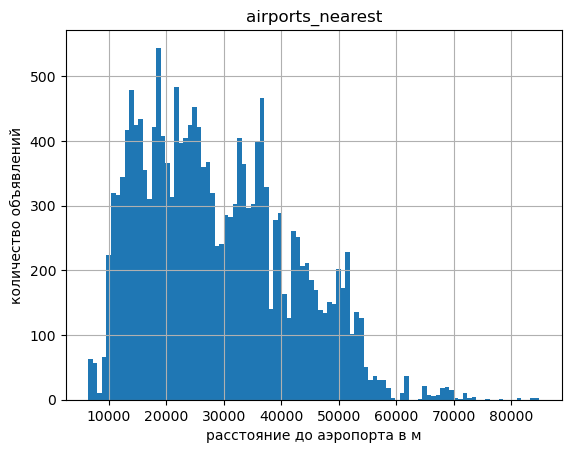

In [96]:
data.hist('airports_nearest', bins=100);
plt.xlabel("расстояние до аэропорта в м");
plt.ylabel("количество объявлений");

Распределение объектов относительно расстояния до аэропорта более равномерное, чем до центра города. Большинство предложений будет иметь удаленность 10-40 км от аэропорта.

12. Расстояние до парка

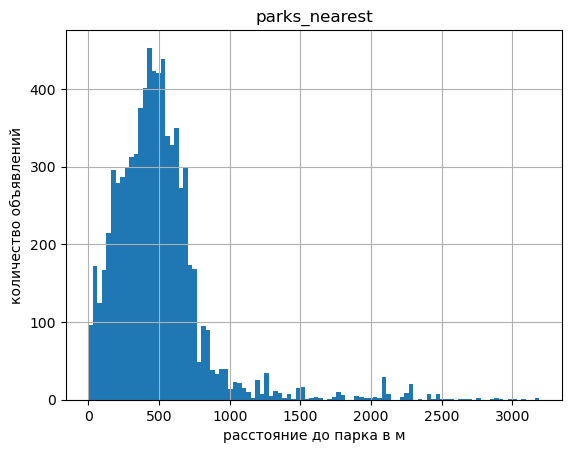

In [97]:
data.hist('parks_nearest', bins=100);
plt.xlabel("расстояние до парка в м");
plt.ylabel("количество объявлений");

Большая часть предложений с заполненным значением parks_nearest - это квартиры, расположенные примерно в полукилометре от парка.

13. День и месяц публикации объявления

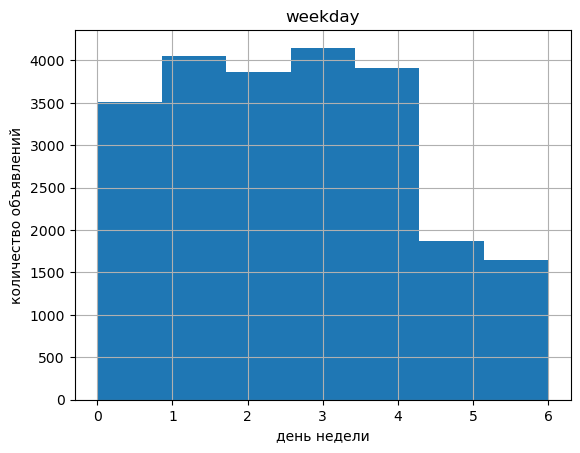

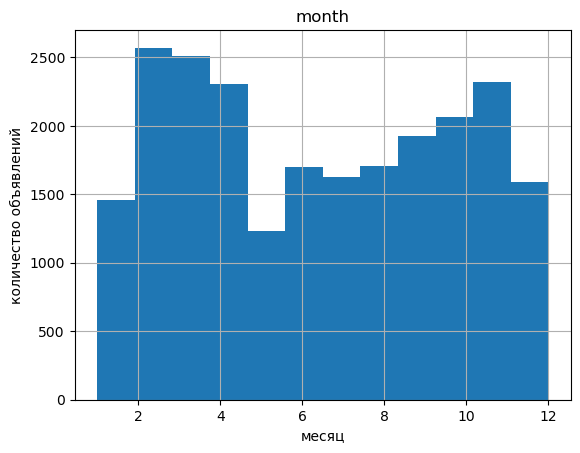

In [98]:
data.hist('weekday', bins=7);
plt.xlabel("день недели");
plt.ylabel("количество объявлений");
data.hist('month', bins=12);
plt.xlabel("месяц");
plt.ylabel("количество объявлений");

Интересный факт - к выходным количество публикаций уменьшается вдвое, а самый "мертвый" месяц продаж - май, а не январь.

**Промежуточный вывод:**  
Отбросив аномальные и редкие значения из базы, сформировался своеобразный портрет усредненного предложения.   
В базе преобладают варианты с небольшой площадью 30-70 метров, и жилой площадью 15-30 метров.  
Это варианты 1-комнатных и 2-комнатных квартир, занимающих более 2/3 от общего числа предложений.  
Среднестатистическая квартира будет иметь высоту потолка около 2.7 метров, кухню не более 10м, будет расположена на 2-5 этаже в доме высотой 5-9 этажей, причем вероятно не будет занимать последний этаж.  
В случае, если у варианта будет указаны картографические данные, то расстояние до центра будет до 20 км, до парка не более 1 км, а до аэропорта до 40 км.  
И в продажу такой "усредненный вариант" поступит в будний день весной (с февраля по март).

<h4>Изучение скорости продажи квартир</h4>

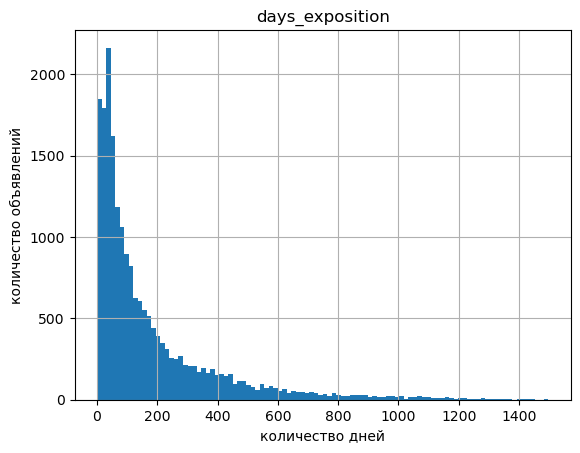

In [99]:
data.hist('days_exposition', bins=100);
plt.xlabel("количество дней");
plt.ylabel("количество объявлений");

Максимальные значения в 1400+ дней сильно уменьшают масштаб графика. Стоит рассмотреть детальнее диапазон до 200 дней, где сосредоточено максимальное количество значений:

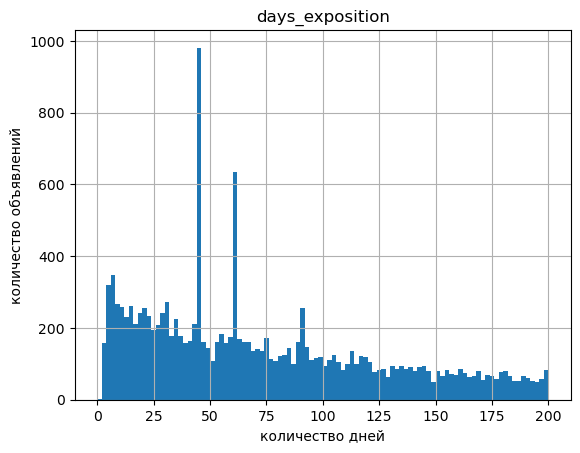

In [100]:
data.hist('days_exposition', bins=100, range=(0,200));
plt.xlabel("количество дней");
plt.ylabel("количество объявлений");

При масштабровании стали видны явные пиковые значения. Все они до 100 дней, поэтому масштаб можно еще раз увеличить:

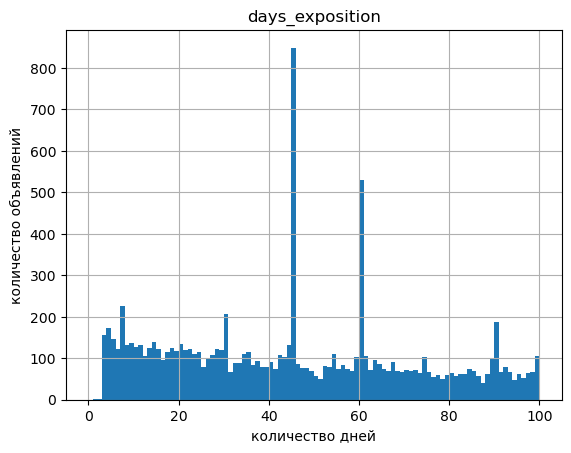

In [101]:
data.hist('days_exposition', bins=100, range=(0,100));
plt.xlabel("количество дней");
plt.ylabel("количество объявлений");

На графике видны пиковые значения в 7, 30, 45, 60 и 90. Причем большинство объявлений было снято с продажи по истечении 45 или 60 дней. Такие "ровные" цифры могут означать единичную итерацию публикации. Возможно это максимальный срок публикации для той или иной локации, или того или иного типа пользователя (собственник или агент). Суммарно почти 2000 значений, попадающих в эти сроки. 
  
  
На текущий момент, срок публикации объявления для СПБ и ЛО на сервисе Яндекс.Недвижимость ограничен 120 днями. Но возможно так было не всегда. Стоит посмотреть на распределение среднего срока продажи по годам:

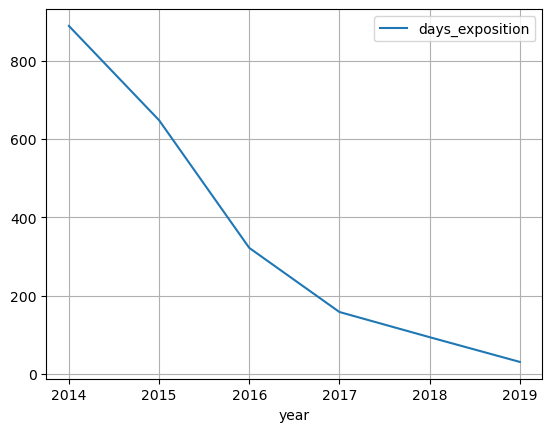

In [102]:
data.pivot_table(index='year', values='days_exposition', aggfunc='mean').plot(grid=True, style='-');

In [103]:
data.pivot_table(index='year', values='days_exposition', aggfunc='mean')

,days_exposition
year,
2014,888.619019
2015,647.948730
2016,322.128235
2017,158.520737
2018,94.256042
2019,31.117031


Интересная тенденция - за 5 лет срок продажи объекта сократился более чем в 28 раз! И даже за год - с 2018 по 2019 произошло снижение срока продажи в 3 раза.

In [104]:
print('Среднее значение дней продажи', data['days_exposition'].mean())
print('Медианное значение дней продажи', data['days_exposition'].median())
print('Минимальное количество дней продажи', data['days_exposition'].min())
print('Максимальное количество дней продажи', round(data['days_exposition'].max(),1))

Среднее значение дней продажи 179.75578
Медианное значение дней продажи 95.0
Минимальное количество дней продажи 1.0
Максимальное количество дней продажи 1497.0


Разница среднего и медианного значения показывает, как сильно влияют продажи ранних лет на среднее.
К тому же максимальный срок продажи в 4 с лишним года говорит о том, что на среднюю продолжительность продажи могут повлиять единичные объекты, переоцененные, либо неликвидные.

**Промежуточные выводы:**  
За период с 2014 по 2019 год произошло снижение срока продажи объектов в 28 раз. При этом, на момент выгрузки средний срок продажи за прошедший период 2019 года был равен 31 дню.  
В целом, оптимальным сроком продажи можно считать 3 месяца (медианное значение 95 дней), а вот продолжительность продажи выше среднего в 180 дней - уже длительное значение.

<h4>Исследование факторов влияния на полную стоимость объекта</h4>

In [105]:
#выберем нужные столбцы в новый датафрейм, с помощью которого будет исследовать зависимость величин
last_price_correlation = data[['last_price','total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_category','weekday','month','year']]

**Зависимость цены от общей площади:**

In [106]:
#вычислим коэффициент Пирсона
last_price_correlation['last_price'].corr(last_price_correlation['total_area'])

0.7823167758086828

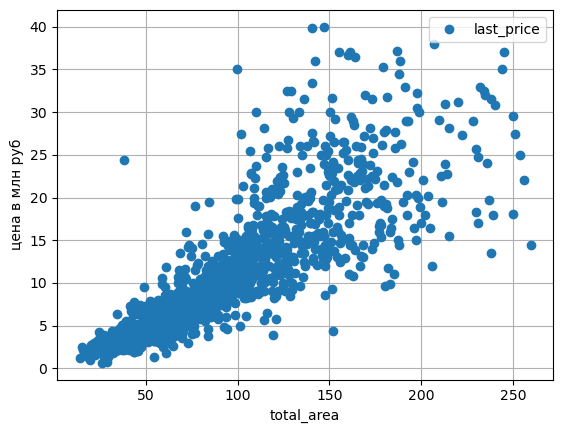

In [107]:
last_price_correlation.pivot_table(index='total_area',values='last_price',aggfunc='mean').plot(grid=True, style='o');
plt.ylabel("цена в млн руб");

Как и ожидалось, цена и площадь достаточно сильно связанные величины. До 150 метров зависимость практически линейна, а вот выше 150 метров варианты весьма различны по цене.

**Зависимость цены от жилой площади:**

In [108]:
#вычислим коэффициент Пирсона
last_price_correlation['last_price'].corr(last_price_correlation['living_area'])

0.6814248174348103

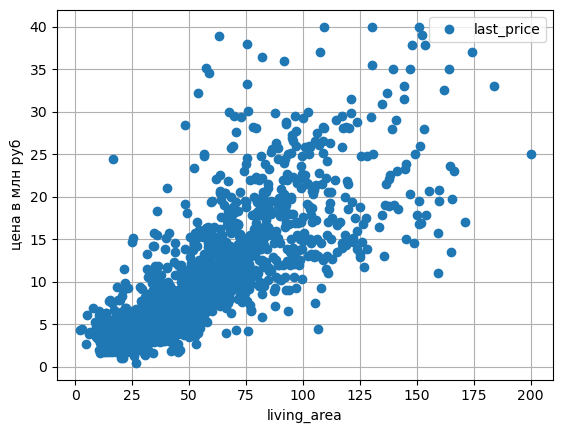

In [109]:
last_price_correlation.pivot_table(index='living_area',values='last_price',aggfunc='mean').plot(grid=True, style='o');
plt.ylabel("цена в млн руб");

Видно, что рассеивание свыше 50квм жилой площади достаточно обширное. Но ДО этого значения зависимость также весьма линейна. То есть можно сказать ,что в квартирах с жилой площадью до 50м, цена растет соответственно увеличению площади.

**Зависимость цены от площади кухни:**

In [110]:
#вычислим коэффициент Пирсона
last_price_correlation['last_price'].corr(last_price_correlation['kitchen_area'])

0.5776826486196974

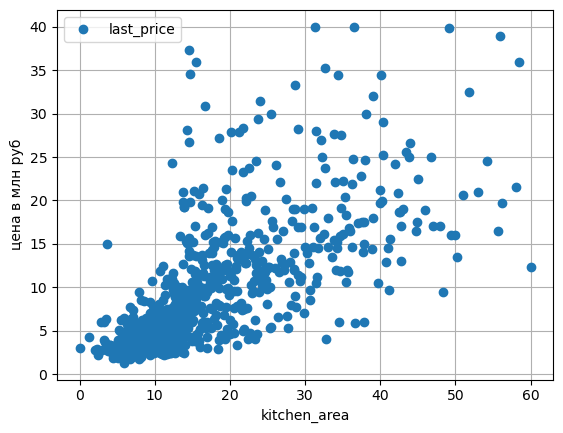

In [111]:
last_price_correlation.pivot_table(index='kitchen_area',values='last_price',aggfunc='mean').plot(grid=True, style='o');
plt.ylabel("цена в млн руб");

Рассеивание все больше, и коэффициент Пирсона показывает, что сильной зависимости от площади кухни нет. Однако заметна плотность точек до 10 кв.м. - это как раз тот диапазон, где увеличение площади кухни прямо влияет на увеличение цены.

**Зависимость цены от количества комнат:**

In [112]:
#вычислим коэффициент Пирсона
last_price_correlation['last_price'].corr(last_price_correlation['rooms'])

0.48886251681543424

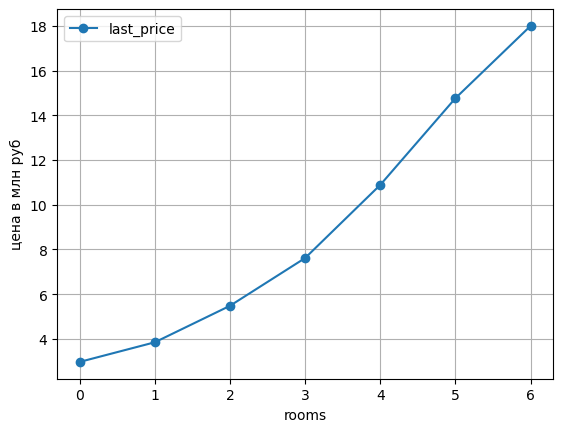

In [113]:
last_price_correlation.pivot_table(index='rooms',values='last_price',aggfunc='mean').plot(grid=True, style='-o');
plt.ylabel("цена в млн руб");

График наглядно демонстрирует увеличение цены при увеличении комнатности квартиры. А вот коэффициент корреляции в отрыве от визуализации мог бы ввести в заблуждение.

**Зависимость цены от этажа:**

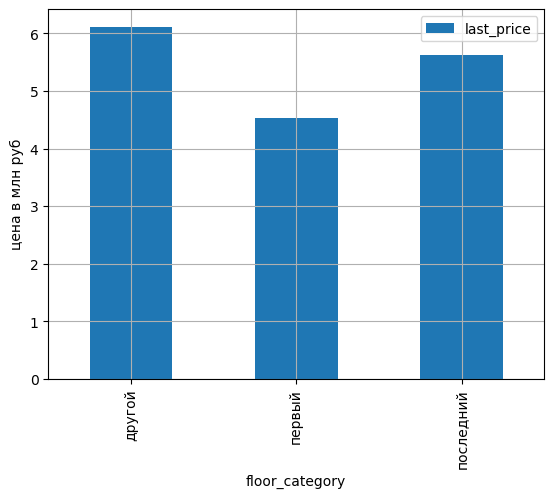

In [114]:
last_price_correlation.pivot_table(index='floor_category',values='last_price',aggfunc='mean').plot(grid=True, kind='bar');
plt.ylabel("цена в млн руб");

Однозначно: квартиры на первом этаже дешевле. Также квартиры на последнем этаже немного теряют в цене относительно объектов на средних этажах.

**Зависимость цены от дня недели публикации объявления:**

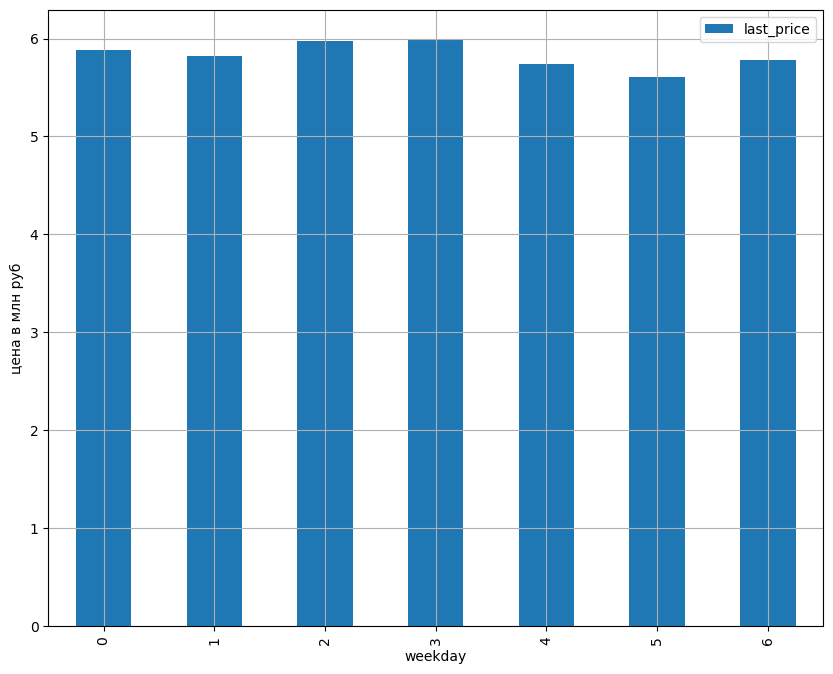

In [115]:
last_price_correlation.pivot_table(index='weekday',values='last_price',aggfunc='mean').plot(grid=True, kind='bar', figsize=(10,8));
plt.ylabel("цена в млн руб");

Судя по графику, колебания средней цены в зависимости от дня появления объекта в продаже не превышают даже полумиллиона рублей. Соответственно зависимости финальной цены объекта от этого параметра нет.

**Зависимость цены от месяца публикации объявления:**

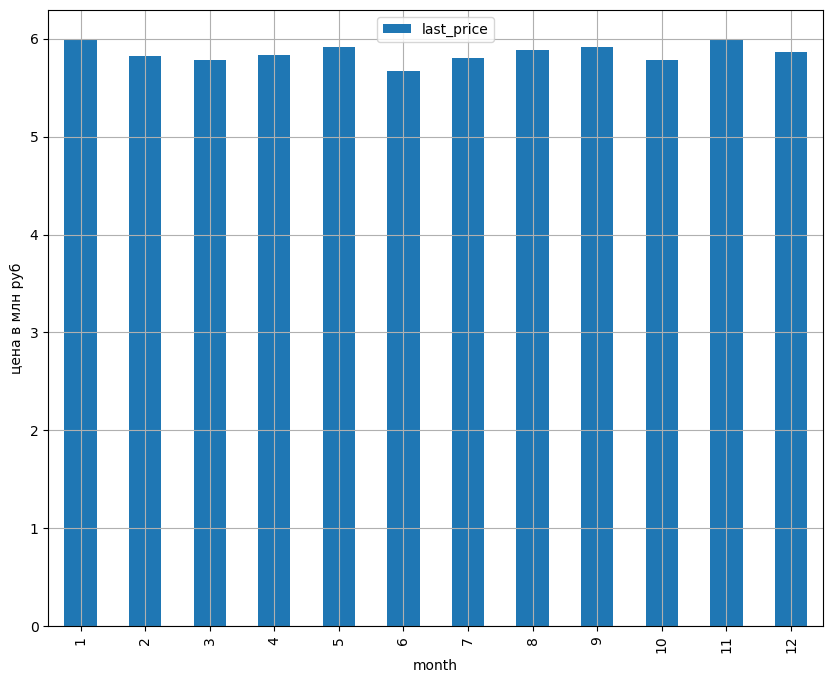

In [116]:
last_price_correlation.pivot_table(index='month',values='last_price',aggfunc='mean').plot(grid=True, kind='bar', figsize=(10,8));
plt.ylabel("цена в млн руб");

Также, как и с днями недели, график показывает совершенно небольшое отклонение средней цены от месяца к месяцу, не превышающее 0,5 млн. Это говорит об отсуствии зависимости.

**Зависимость цены от года публикации:**

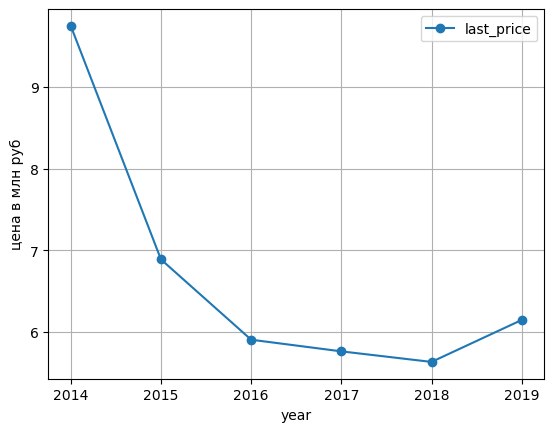

In [117]:
last_price_correlation.pivot_table(index='year',values='last_price',aggfunc='mean').plot(grid=True, style='-o');
plt.ylabel("цена в млн руб");

Получилась весьма интересная кривая: в период с 2014 по 2015 год было значительное падение цены, что могло быть связано с кризисом 2014 года. Далее снижение цен медленно нивелировалось и к 2018 году достигло "плато", после чего цены снова пошли вверх. Этому повышению могли способствовать снижающиеся ипотечные ставки и скорректировавшееся соотношение спроса и предложения, т.к. в 2018 году рынок жилья в новостройках претерпел изменения в связи с переходом на эскроу-счета.

**Промежуточные выводы:**  
На цену квартиры однозначно влияет общая площадь, комнатность и этаж (НЕ первый).  
Площадь кухни и жилая площадь уже немного меньше влияют на цену, за исключением, если площадь кухни не больше 10м, а жилая не больше 50м.
День и месяц публикации не важны для конечного ценообразования, а вот посмотрев на распределение цен по годам, появился вывод, что на момент выгрузки наблюдался впервые за 5 лет рост стоимости жилья.

<h4>Исследование цены квадратного метра</h4>

Необходимо выявить 10 населенных пунктов с максимальным количеством объявлений, и проанализировать распределение цены квадратного метра.

In [141]:
#создадим новую таблицу с количеством предложений по каждому городу
top_10_count = data.pivot_table(index='locality_name', values='last_price',aggfunc='count') \
.sort_values(by='last_price', ascending=False).head(10)

,last_price,one_sqm_price
Санкт-Петербург,15226,111497.125000
Пушкин,363,102931.218750
Кудрово,449,95090.093750
Парголово,325,90291.781250
Мурино,555,85697.281250
Шушары,433,78273.281250
Колпино,335,75295.343750
Всеволожск,392,68700.554688
Гатчина,303,68625.140625
Выборг,230,57884.011719


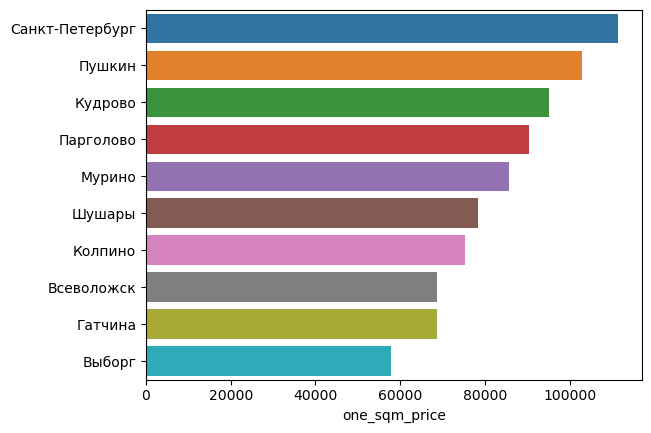

In [142]:
#добавим в таблицу столбец со средним значением одного квадратного метра
top_10_count = (
    top_10_count
    .join(
        data.pivot_table(index='locality_name',values='one_sqm_price',aggfunc='mean')
    )
)
top_10_count = top_10_count.sort_values(by="one_sqm_price", ascending=False)
top_10_count.index.name = None
display(top_10_count)
sns.barplot(data=top_10_count, x="one_sqm_price", y=top_10_count.index);

Как и ожидалось, на 1м месте списка Санкт-Петербург, следом идут крупные пригородные районы Мурино и Кудрово с большой площадью новой застройки. А на последнем месте в топ-10 удаленные города Ленобласти - Гатчина и Выборг.

In [120]:
top_10_count.loc[top_10_count['one_sqm_price'] == top_10_count['one_sqm_price'].max()]

,last_price,one_sqm_price
Санкт-Петербург,15226,111497.125


In [121]:
top_10_count.loc[top_10_count['one_sqm_price'] == top_10_count['one_sqm_price'].min()]

,last_price,one_sqm_price
Выборг,230,57884.011719


Максимальная цена квадратного метра будет в Санкт-Петербурге, а минимальная в самом удаленном городе из списка - Выборге. При этом интересно заметить, что цена квадратного метра в Пушкине достаточно велика и близка к значению Санкт-Петербурга. Это можно объяснить 2мя параметрами: во-первых,  Пушкин - район Санкт-Петербурга, а во-вторых, это парковая зона.

**Промежуточные выводы:**  
Более 60% занимают предложения в Санкт-Петербурге, они же являются и наиболее дорогими.  
На втором месте по стоимости квадратного места среди популярных районов - город Пушкин.  
Последнее место в топ-10 локаций базы занимает город Выборг, удаленный от СПб на границу Ленинградской области с Финляндией. Там цена квадратного метра ниже в 2 раза, а объем предложения в 66 раз.

<h4>Исследование изменения цены квадратного метра в зависимости от удаленности от центра города</h4>

Необходимо исследовать, как изменяется цена квадратного метра в черте Санк-Петербурга при удалении от центра города. Для этого необходимо отобрать объявления, расположенные именно в СПб:

In [122]:
only_spb = data.query('locality_name == "Санкт-Петербург"')

In [123]:
#считаем среднюю цену кв метра для каждого километра
only_spb.pivot_table(index='city_centers_in_kilometers', values='one_sqm_price', aggfunc='mean')

,one_sqm_price
city_centers_in_kilometers,
0.0,150053.921875
1.0,144322.000000
2.0,136532.406250
3.0,117306.070312
4.0,127476.695312
5.0,134190.968750
6.0,136650.671875
7.0,138495.875000
8.0,123606.906250


Полученные данные выведем в график:

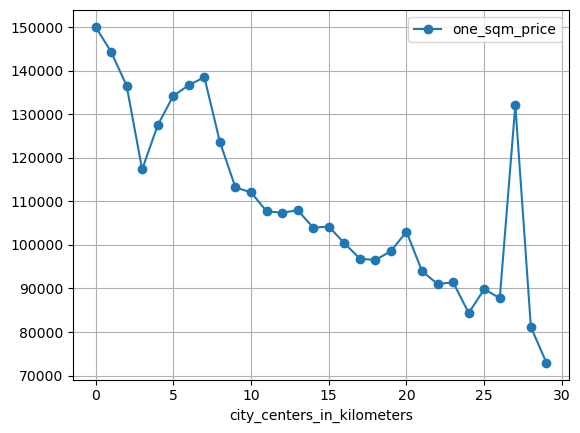

In [124]:
only_spb.pivot_table(index='city_centers_in_kilometers', values='one_sqm_price', aggfunc='mean').plot(grid=True, style='-o');

Заметны два выбивающихся значения: падение цены в районе 3 км от центра, и резкое увеличение в районе 27 км от ценра.  
Стоит проанализировать, почему это происходит.  
Есть предположение, что пик на 27 км связан с увеличением застройки с малогабаритными квартирами на удалении от центра города. А в небольших квартирах цена квадратного метра выше.  

Показателен в данном случае будет не только график зависимости комнатности от расстояния до центра, но и график с общей стоимостью лотов:

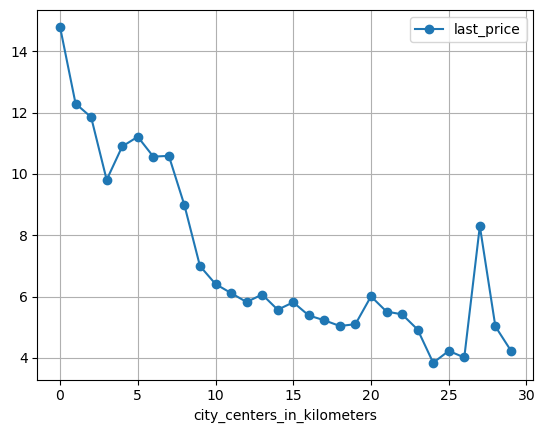

In [125]:
#построим график зависимости общей цены от удаленности от центра
only_spb.pivot_table(index='city_centers_in_kilometers', values='last_price', aggfunc='mean').plot(grid=True, style='-o');

Заметно, что при построении графика заивисомсти с общей ценой, пиковые значения провалов и повышений уже не такие острые. Предположительно, провал в районе 3 км связан с квартирами большого метража, что характерно для исторической застройки в центре. (Цена квадрата сильнее уходит вниз, чем общая цена, значит больше площадь). А вот пик в районе 27 км показывает, что не только малогабаритные квартиры могут быть причиной увеличения стоимости квадратного метра, но и в целом подтверждают тот факт, что именно в этом районе жилье выше по стоимости. Вероятно, это связано с появлением там жилья более высокого уровня. Для этого чуть позже проверим высоты потолков.

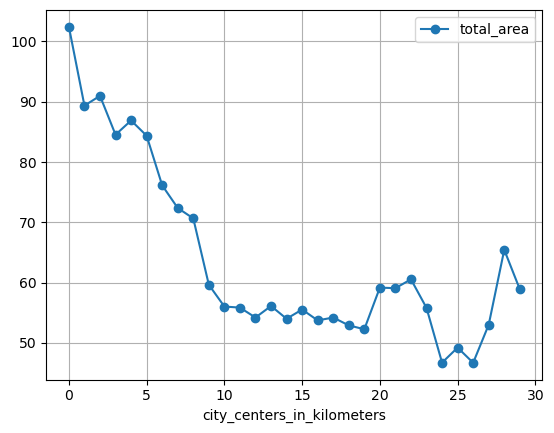

In [126]:
#график распределения площади в удалении от центра
only_spb.pivot_table(index='city_centers_in_kilometers', values='total_area', aggfunc='mean').plot(grid=True, style='-o');

Действительно, виден небольшой рост площади около 3км от центра, который нивелирует более низкую стоимость квадрата, а также резкий пик площади в интересующей точке 27 км.

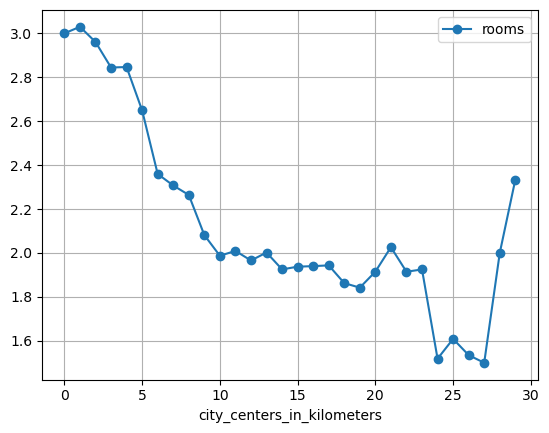

In [127]:
#построим график распределения комнатности в зависимости от удаленности от центра
only_spb.pivot_table(index='city_centers_in_kilometers', values='rooms', aggfunc='mean').plot(grid=True, style='-o');

Предложенная выше гипотеза о пике стоимости квадратного метра на расстоянии 27 км из-за уменьшения комнатности квартир также подтвердилась: действительно, в удаленности от центра средняя комнатности резко падает. При этом ранее был рост площади. Мало комнат, но большая площадь - действительно может быть признаком жилья высокого класса. Для него также характерны высокие потолки. Проверим:

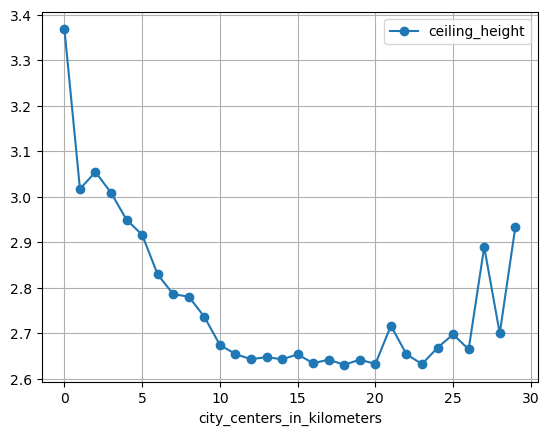

In [128]:
#построим график средних высот потолка в зависимости от удаленности от центра
only_spb.pivot_table(index='city_centers_in_kilometers', values='ceiling_height', aggfunc='mean').plot(grid=True, style='-o');

Самые высокие потолки, логично, в исторических зданиях самого центра. Но и в интересующей локации после 25 км также есть варианты с высокими потолками. Что еще раз подтверждает гипотезу о наличии в том районе комплекса высокого класса.

Снижение стоимости в районе 3 км от центра может быть связано с нюансом недвижимости в центре города. Большинство предложений в таком малом радиусе от центра - это исторические здания, и их состояние может быть различным. Вполне может быть, что в этот диапазон просто попали объекты в плохом состоянии, либо дома, требующие реконструкции, где цена метра ниже готовых к проживанию вариантов.  
Для проверки этой гипотезы нужны данные о годе постройки здания и годе последней реконструкции, которые не представлены в датафрейме.

**Промежуточные выводы:**  
Показатель стоимости жилья в зависимости от удаленности не линеен по всей протяженности, видны всплесковые значения как в самой центральной части города (до 5 км), так и наоборот - на сильно удалении (после 25 км). Но при этом видна общая тенденция - снижения. 
Анализ стоимости, площади, комнатности и высот потолков показал, что на удалении более 25 км от центра есть объекты высокого уровня, которые влияют на стоимость жилья. 

### Общий вывод

Представленные данные позволили выявить несколько зависимостей.

**В первую очередь, сформировать портрет усредненного предложения на рынке Санкт-Петербурга:**
Квартира 1-2 комнатная, с площадью от 30 до 70 метров, кухней 7-10 метров, на низком этаже (2-4), в среднеэтажном доме (5-9 эт) и высотой потолка около 2,7 метров.
Такой объект будет расположен на расстоянии 20 км от центра и в пределах не более 40 км от аэропорта. При этом средняя цена квадратного метра будет около 100 тыс руб.  
А в продажу квартира поступит в будние дни, в феврале-апреле или сентябре-ноябре.

**Также получилось исследовать срок продажи, и установить, что:**  
- срок продажи за 5 лет сократился в 28 раз  
- 10% процентов объявлений снимаются по истечении срока публикации без продления  
- оптимальным сроком продажи можно считать 3 месяца (медианное значение 95 дней), а вот продолжительность продажи выше среднего в 180 дней - уже выбивающееся значение  
- существуют объекты, продаваемые на протяжении почти 4х лет, а также объекты, проданные за 1 день.  

**При анализе взаимосвязи стоимости от различных факторов, выяснилось:**  
1. На стоимость объекта в первую очередь влияет площадь квартиры.  
2. Чуть менее, но все же оказывают влияние факторы числа комнат и расположения на определенном этаже: классически, квартиры на первом этаже теряют в цене, и немного меньше цена у объектов последнего этажа. А большее количество комнат дает увеличение цены.  
3. Дата публикации практически не влияет на стоимость, однако была обнаружена тенденция снижения стоимости жилья с 2014 по 2018 год, и начало плавного роста цены в 2019.  

**Проверка распределения стоимости квадратного метра по топ-10 населенным пунктам по количеству объявлений:**  
Санкт-Петербург является лидером по количеству и стоимости предложений - более 15 тысяч квартир со средней ценой 111 тыс руб за квадратный метр.  
В противовес в Выборге всего 230 предложений с ценой почти 58 тыс руб за метр. При этом между этими значениями укладываются самые популярные и густонаселенные районы Петербурга и Ленинградской области - Мурино, Кудрово, Пушкин, Колпино, Всеволожск, Гатчина и Шушары.  

**Проверка стоимости жилья в зависимости от удаленности от центра города показала:**  
Удаление от центра города более чем на 10 км ведет к плавному снижению стоимости, если только в районе не представлен объект бизнес или элит класса.  
А предложения в пределах 5 км от центра могут иметь различный характер стоимости, и требуют отдельного изучения с дополнительными данными.